# PROJECT: 
## Predicting outcomes (Judgement, Judgement Type and Amount Recieved) of US federeal civil cases



---


---


 

## 1. DATASET DETAILS:


*   From US Govt. official website, Federal Judicial Centre, dataset contains datapoints from *1987 to Present*.
*   **Data type:** Structured, text(txt), encoding=*cp1252*, seperator='/'
*   **Shape:** 9,000,000 x 46
*   **Size:** 1.76 GB
*   **Codebook:** https://www.fjc.gov/sites/default/files/idb/codebooks/Civil%20Codebook%201988%20Forward.pdf






Website: https://www.fjc.gov/research/idb

Download Link: https://www.fjc.gov/research/idb/civil-cases-filed-terminated-and-pending-sy-1988-present



---



---

*Please note sometimes during this project I used different tools and libraries which were not required but just to clear concepts.*

### 1.1 Importing Libraires:

In [1]:
import pandas as pd
import numpy as np

import dask.dataframe as dd
import dask.distributed

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import time
import spacy

### 1.2 Lets import the dataset as a Pandas DataFrame


*   Dataset was big but within memory specifications
*   Tested importing using Pandas **chunk method** as well as **dask** dataframe





In [2]:
start = time.time()

usecols = ['CIRCUIT', 'DISTRICT', 'OFFICE', 'ORIGIN', 'FILEDATE',
       'FDATEUSE', 'JURIS', 'NOS', 'RESIDENC',
       'JURY', 'DEMANDED', 'COUNTY', 'PLT', 'DEF', 'TERMDATE', 'TDATEUSE',
       'PROCPROG', 'DISP', 'NOJ', 'AMTREC', 'JUDGMENT',
       'PROSE', 'STATUSCD', 'TAPEYEAR']

dtype={'ARBIT': 'object',
       'DISTRICT': 'object',
       'TRMARB': 'object',
       'OFFICE': 'object',
       'JURY': 'object',
       'MDLDOCK': 'object',
       'PRETRIAL': 'object',
       'SECTION': 'object',
       'SUBSECT': 'object',
       'TRANSDAT': 'object',
       'TRIALEND': 'object',
       'TRIBEGAN': 'object',
       'TRANSORG': 'object',
       'TRANSOFF': 'object',
       'IFP': 'object',
       'STATUSCD': 'object',
       'TITL': 'object'}

chunk = pd.read_csv("/Users/livanshu/Downloads/cv88on.txt",sep='\t',encoding='cp1252',chunksize=100000,low_memory=False)
df = pd.concat(chunk)

end = time.time()
print("Read csv with chunks: ",round(end-start,2),"sec")
df.info()
df.memory_usage(deep=True)

Read csv with chunks:  44.19 sec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Data columns (total 46 columns):
 #   Column    Dtype  
---  ------    -----  
 0   CIRCUIT   int64  
 1   DISTRICT  object 
 2   OFFICE    object 
 3   DOCKET    int64  
 4   ORIGIN    int64  
 5   FILEDATE  object 
 6   FDATEUSE  object 
 7   JURIS     int64  
 8   NOS       int64  
 9   TITL      object 
 10  SECTION   object 
 11  SUBSECT   object 
 12  RESIDENC  int64  
 13  JURY      object 
 14  CLASSACT  int64  
 15  DEMANDED  int64  
 16  FILEJUDG  float64
 17  FILEMAG   float64
 18  COUNTY    int64  
 19  ARBIT     object 
 20  MDLDOCK   object 
 21  PLT       object 
 22  DEF       object 
 23  TRANSDAT  object 
 24  TRANSOFF  object 
 25  TRANSDOC  int64  
 26  TRANSORG  object 
 27  TERMDATE  object 
 28  TDATEUSE  object 
 29  TRCLACT   int64  
 30  TERMJUDG  float64
 31  TERMMAG   float64
 32  PROCPROG  int64  
 33  DISP      int64  
 34  NOJ       int64  
 35

Index             128
CIRCUIT      75795552
DISTRICT    540592196
OFFICE      362339596
DOCKET       75795552
ORIGIN       75795552
FILEDATE    634787748
FDATEUSE    634787748
JURIS        75795552
NOS          75795552
TITL        346114812
SECTION     571394304
SUBSECT     558739552
RESIDENC     75795552
JURY        554649846
CLASSACT     75795552
DEMANDED     75795552
FILEJUDG     75795552
FILEMAG      75795552
COUNTY       75795552
ARBIT       554076523
MDLDOCK     412382188
PLT         641259071
DEF         712979574
TRANSDAT    306194938
TRANSOFF    364068895
TRANSDOC     75795552
TRANSORG    361770247
TERMDATE    634787538
TDATEUSE    612751993
TRCLACT      75795552
TERMJUDG     75795552
TERMMAG      75795552
PROCPROG     75795552
DISP         75795552
NOJ          75795552
AMTREC       75795552
JUDGMENT     75795552
DJOINED     417248748
PRETRIAL    329246568
TRIBEGAN    306646508
TRIALEND    308323253
TRMARB      542705368
PROSE        75795552
IFP         468449009
STATUSCD  

In [3]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR
0,0,90,1,7101462,4,07/21/1971,07/01/1971,3,440,NaN,...,1,NaN,NaN,NaN,NaN,-8,-8,NaN,NaN,1988
1,0,90,1,7300974,4,05/17/1973,02/01/1983,2,890,NaN,...,1,01/20/1988,NaN,NaN,NaN,-8,-8,NaN,NaN,1988
2,0,90,1,7601326,4,01/31/1985,06/01/1985,2,440,NaN,...,-8,NaN,NaN,NaN,NaN,-8,-8,NaN,NaN,1988
3,0,90,1,7700081,3,09/19/1984,05/01/1986,2,442,NaN,...,-8,NaN,NaN,NaN,NaN,-8,-8,NaN,NaN,1988
4,0,90,1,7901559,2,06/15/1979,06/01/1979,2,550,NaN,...,2,NaN,NaN,NaN,NaN,-8,-8,NaN,NaN,1988


In [ ]:
from dask.distributed import Client
client = Client(threads_per_worker=4)
client

/opt/homebrew/lib/python3.9/site-packages/distributed/node.py:181: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52673 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52673/status,
Dashboard: http://127.0.0.1:52673/status,Workers: 2
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52674,Workers: 2
Dashboard: http://127.0.0.1:52673/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:52682,Total threads: 4
Dashboard: http://127.0.0.1:52683/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52677,


## 1.3 Dataset Details:

### 1.3.1 Column details:
*Reference: Codebook*


1.   **CIRCUIT**: Circuit in which the case was filed 
2.   **DISTRICT:** District court in which the case was filed
3.   **OFFICE:** The office within the district where
     the case is filed
4.   **DOCKET:** A number assigned by the Clerks’ office
5.   **ORIGIN:** A single digit code describing the manner in which the case was filed in the district
6.   **FILEDATE:** The date on which the case was filed in the district
7.   **FDATEUSE:** This field is used to identify cases within a given statistical year
8.   **JURIS:** The code which provides the basis for the U.S. district court jurisdiction in the case
9.   **NOS:** A 3 digit statistical code representing the nature of the suit filed
10.  **TITL:** optional
11.  **SECTION:** optional
12.  **SUBSECTION:** optitonal
13.  **RESIDENC:** Involves diversity of citizenship for the plaintiff and defendant
14.  **JURY:** Indicates the party or parties demanding a jury trial
15.  **CLASSACT:** Involves an allegation by the plaintiff that the complaint meets the prerequisites of a Class Action
16. **DEMANDED:** Monetary Amount Demanded in thousands
17. **FILEJUDG:** The statistical code for the judge to whom the case was originally assigned
18.  **FILEMAG:** The code of the magistrate judge to whom all or part of the case was originally referred
19.  **COUNTY:** County of Residence
20. **ARBIT:** This field is used only by the courts  participating in the Formal Arbitration Program
21.  **MDLOCK:** A 4 digit multi district litigation docket number
22.  **PLT:** Name of first listed plantiff (who files)
23.  **DEF:** Name of first listed defendent
24.  **TRANSDAT:** The date when the papers were received in the receiving district for a transferred  case
25.  **TRANSOFF:** The office number of the district losing the case
26.  **TRANSDOC:** The docket number of the case in the losing district
27.  **TRANSORG:** The origin number of the case in the losing district
28. **TERMDATE:** The date of the final judgment or the order disposing of the case
29.  **TDATEUSE:** This field is used to identify cases within a given statistical or fiscal year of termination as counted by the AO in published reports.
30.  **TRCLACT:** A code that indicates a case involving allegations of class action
31. **TERMJUDG:** The statistical code for the judge assigned at the time of disposition
32. **TERMMAG:** The statistical code for the magistrate judge assigned at the time of disposition
33. **PROCPROG:** The point to which the case had progressed when it was disposed of
34. **DISP:** The manner in which the case was disposed of
35. **NOJ:** Nature of Judgement
36. **AMTREC:** Dollar amount received in thousands
37. **JUDGMENT:** Final judgment in favor of
38. **DJOINED:** optional
39. **PRETRIAL:** optional
40. **TRIBEGAN:** optional
41. **TRIALEND:** optional
42. **TRMARB:** Termination arbitration code
43. **PROSE:** Pro Se (on one's behalf)
44. **IFP:** Informa Pauperis (court fee not paid)
45. **STATUSCD:** Status code to identify the type of record
46. **TAPEYEAR:** Statistical year label on data files obtained from the Administrative Office of the United States Courts.






In [ ]:
import dask.dataframe as dd

start = time.time()
dtype={'ARBIT': 'object',
       'DISTRICT': 'object',
       'TRMARB': 'object',
       'OFFICE': 'object',
       'JURY': 'object',
       'MDLDOCK': 'object',
       'PRETRIAL': 'object',
       'SECTION': 'object',
       'SUBSECT': 'object',
       'TRANSDAT': 'object',
       'TRIALEND': 'object',
       'TRIBEGAN': 'object',
       'TRANSORG': 'object',
       'TRANSOFF': 'object',
       'IFP': 'object',
       'STATUSCD': 'object',
       'TITL': 'object'}

df_dask = dd.read_csv("/Users/livanshu/Downloads/cv88on.txt",sep='\t',encoding='cp1252',dtype=dtype, 
             blocksize=1000000)
end = time.time()
print("Read csv with dask: ",round(end-start,2),"sec")

#df_dask = df_dask.compute(scheduler="threads") # convert to pandas
#end = time.time()
#print("Convert dasf df to pandas: ",round(end-start,2),"sec")

df_dask.info()

Read csv with dask:  0.34 sec
<class 'dask.dataframe.core.DataFrame'>
Columns: 46 entries, CIRCUIT to TAPEYEAR
dtypes: object(24), float64(4), int64(18)

## 1.4 Importing times:


*   Chunk Method:   *42.9 sec*
*   Dask: *0.34 sec*



# 2. DATA PROCESSING:
### Now as the dataset is in the memory as Pandas Dataframe, lets ***downcast*** the dataset by the least memory datatype it so it takes less memory or i.e. converting int64 to int8 wherever required
## 2.1 Downcasting:

In [4]:
## Lower memory size by downcasting

def downcast_dtype(df):
  print("Dataframe Info before:\n")
  df.info(verbose=False)
  float_cols = df.select_dtypes('float').columns
  df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')

  int_cols = df.select_dtypes('integer').columns
  df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
  print("\n\nDataframe Info after:\n")
  df.info(verbose=False)

downcast_dtype(df)


Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Columns: 46 entries, CIRCUIT to TAPEYEAR
dtypes: float64(4), int64(18), object(24)
memory usage: 3.2+ GB


Dataframe Info after:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Columns: 46 entries, CIRCUIT to TAPEYEAR
dtypes: float32(4), int16(4), int32(3), int8(11), object(24)
memory usage: 2.1+ GB


## 2.2 NaN Values:
* Replacing the string/int "-8"/-8 to NaN in whole dataset
* As per *codebook* reference, missing fields are denoted by "-8"

In [5]:
def replace_values_from_dataset(df,values,newvalues):
  for value in values:
    for i in range(len(df.columns)):
      (df[df.columns[i]]).replace(values,newvalues,inplace=True)
    return df.head(10)

replace_values_from_dataset(df,('-8',-8),np.nan) #Used string and integer both because of different column datatypes

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR
0,0,90,1,7101462,4.0,07/21/1971,07/01/1971,3.0,440,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
1,0,90,1,7300974,4.0,05/17/1973,02/01/1983,2.0,890,NaN,...,1.0,01/20/1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
2,0,90,1,7601326,4.0,01/31/1985,06/01/1985,2.0,440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
3,0,90,1,7700081,3.0,09/19/1984,05/01/1986,2.0,442,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
4,0,90,1,7901559,2.0,06/15/1979,06/01/1979,2.0,550,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
5,0,90,1,7902405,1.0,09/10/1979,09/01/1979,2.0,442,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
6,0,90,1,8000684,1.0,03/17/1980,03/01/1980,1.0,370,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
7,0,90,1,8000801,4.0,07/18/1984,07/01/1984,2.0,190,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
8,0,90,1,8001844,4.0,03/01/1988,02/01/1988,2.0,440,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
9,0,90,1,8001939,4.0,05/08/1985,05/01/1985,1.0,150,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988


### 2.2.1 Replacing 0,4 & -8 from Judgment to NaN

*   These values are either missing or Unknown

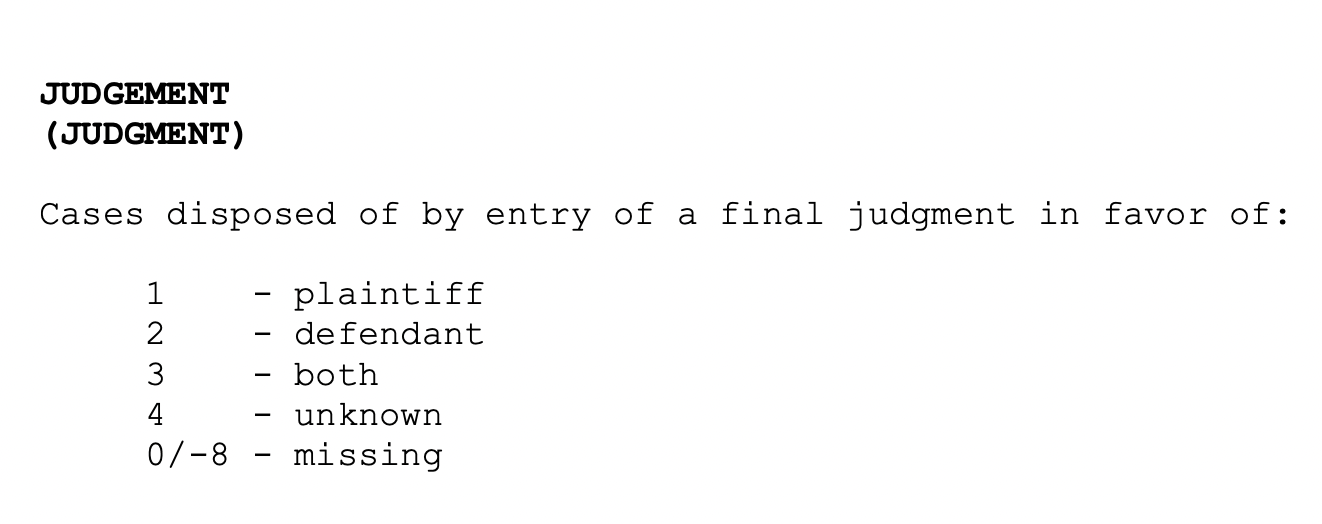

In [6]:
df.replace({"JUDGMENT":{0:np.nan,4:np.nan}},inplace=True)
df.head()


,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR
0,0,90,1,7101462,4.0,07/21/1971,07/01/1971,3.0,440,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
1,0,90,1,7300974,4.0,05/17/1973,02/01/1983,2.0,890,NaN,...,1.0,01/20/1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
2,0,90,1,7601326,4.0,01/31/1985,06/01/1985,2.0,440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
3,0,90,1,7700081,3.0,09/19/1984,05/01/1986,2.0,442,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
4,0,90,1,7901559,2.0,06/15/1979,06/01/1979,2.0,550,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988


*   Subsetting **TAPEYEAR**

In [7]:
df = df[df.TAPEYEAR != 2099]  ## Tapeyear 2099 represents pending cases i.e. we do not need them as they have no judgment

## 2.3 Data modification

### 2.3.1 Defining function to get stats of a column

In [26]:
def get_column_stats(column):
  val_counts_des = df[column].value_counts().describe()
  val_count = df[column].value_counts()
  nunique = df[column].nunique()
  unique = df[column].unique()
  null_values = df[column].isnull().sum()
  percent_null = (null_values/len(df[column]))*100
  print("\033[1mNumber of NaN:\033[0m", null_values)
  print("\033[1mPercentage of NaN:\033[0m", round(percent_null,2),"%")
  print("\033[1mNumber of Unique Values: \033[0m",nunique, "\n\n\033[1mUnique Values: \033[0m",unique, "\n\n\033[1mDescription of Column:\033[0m\n", val_counts_des)
  print("\n\033[1mTop  Value Count: \033[0m \n", val_count[:])
  print("\n| \033[1m",val_counts_des.index[4], "of", column,"column's data appear in", int(val_counts_des[4].round()), "rows at most \033[0m" )
  print("\n| \033[1m",val_counts_des.index[5], "of", column,"column's data appear in", int(val_counts_des[5].round()), "rows at most \033[0m" )


In [9]:
cols_get_stats = ['JUDGMENT']
for cols in cols_get_stats:
  get_column_stats(cols)

Number of NaN: 6828601
Percentage of NaN: 77.2 %
Number of Unique Values:  3 

Unique Values:  [ 1. nan  2.  3.] 

Description of Column:
 count    3.000000e+00
mean     6.720850e+05
std      5.762147e+05
min      6.094100e+04
25%      4.053905e+05
50%      7.498400e+05
75%      9.776570e+05
max      1.205474e+06
Name: JUDGMENT, dtype: float64

Top  Value Count:  
 2.0    1205474
1.0     749840
3.0      60941
Name: JUDGMENT, dtype: int64

|  25% of JUDGMENT column's data appear in 405390 rows at most 

|  50% of JUDGMENT column's data appear in 749840 rows at most 


In [10]:
df["DEMANDED"].value_counts()

0.0       6611765
75.0       190644
9999.0     181403
50.0       120319
1000.0      66189
           ...   
8361.0          1
3479.0          1
8620.0          1
7062.0          1
6815.0          1
Name: DEMANDED, Length: 7355, dtype: int64

In [11]:
df.tail()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR
9474415,11,3J,6,2100044,5.0,06/23/2021,06/01/2021,3.0,530,28,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021
9474418,11,3J,6,2100047,1.0,07/08/2021,07/01/2021,3.0,555,42,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021
9474420,11,3J,6,2100049,1.0,07/15/2021,07/01/2021,3.0,555,42,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021
9474432,11,3J,6,2100061,1.0,08/19/2021,08/01/2021,3.0,555,42,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021
9474440,11,3J,6,2100069,1.0,09/07/2021,09/01/2021,3.0,530,28,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021


### 2.3.2 Data Collection History throughout the years


*   Datapoints are time based
*   Lets check the timeline of data collection



In [8]:
df_timeline = df.groupby("TAPEYEAR")
df_timeline = df_timeline.count()
df_timeline_cumm = df_timeline.cumsum(axis = 0)

In [9]:
df_timeline_cumm.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,AMTREC,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD
TAPEYEAR,,,,,,,,,,,,,,,,,,,,,
1988,238753,238753,238753,238753,238753,238753,238753,238753,238753,0,...,45552,73991,73664,24402,6961,6762,0,0,0,0
1989,473972,473972,473972,473972,473971,473972,473972,473972,473972,0,...,113749,153634,157533,52471,14528,14162,0,0,0,0
1990,687894,687894,687894,687894,687893,687894,687894,687894,687894,0,...,214033,225256,248400,82549,22141,21664,6672,0,0,0
1991,899607,899607,899607,899607,899606,899607,899607,899607,899607,0,...,362154,290751,305255,106472,28682,28154,9991,0,0,0
1992,1202814,1202814,1202814,1202814,1202813,1202814,1202814,1202813,1202814,0,...,665361,385549,386444,142971,34302,36887,16635,0,0,0


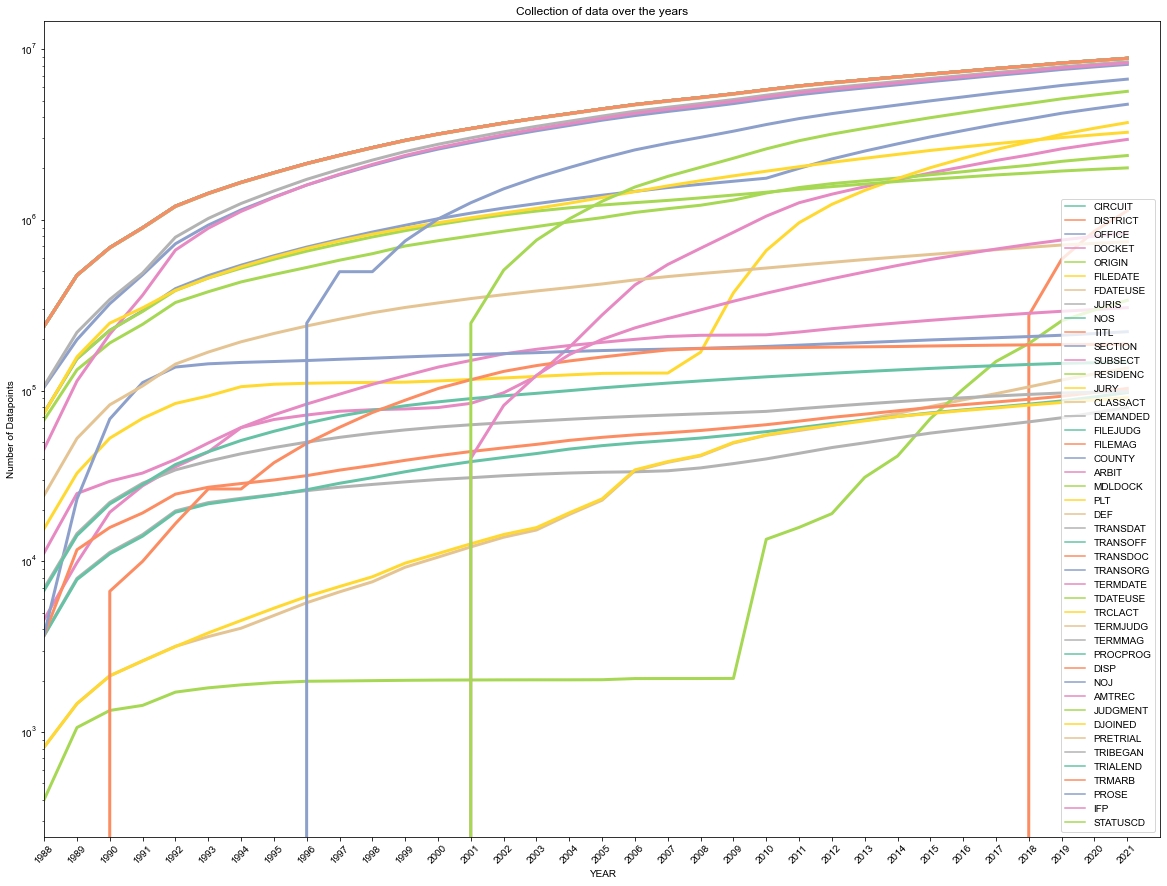

In [10]:
plt.figure(figsize=(20,15))
ax = sns.lineplot(data=df_timeline_cumm,dashes=False,linewidth=3,palette='Set2')
sns.set_style('white')

## Labels and Title
ax.set(xlabel="YEAR",ylabel="Number of Datapoints",title="Collection of data over the years")

## Axes limits, ticks and Scale
ax.set(xlim=(1988,2022) , xticks=(range(1988,2022)),yscale='log')
#ax.set(ylim=(0,10000000) , yticks=[0,10000000])
plt.xticks(rotation=45) #ax.set do not work as it needs xticks names too
plt.show()

## 2.4 Handling Missing Values


*   Lets see missing value count and percentage of every column



In [11]:
missing_value_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_value_count.sum()
total_percentage_missing = (total_missing/total_cells)*100
percent_missing = round(df.isnull().mean()*100,1)
missing_value_count = missing_value_count.to_frame().merge(percent_missing.to_frame(), left_index=True, right_index=True)
print("Missing Values Count:")
print(missing_value_count)
print("\nTotal Percentage of missing data:",round(total_percentage_missing,2),'%')

Missing Values Count:
              0_x    0_y
CIRCUIT         0    0.0
DISTRICT        0    0.0
OFFICE          0    0.0
DOCKET          0    0.0
ORIGIN        550    0.0
FILEDATE        0    0.0
FDATEUSE        0    0.0
JURIS           1    0.0
NOS             0    0.0
TITL      7713876   87.2
SECTION    700494    7.9
SUBSECT   5884914   66.5
RESIDENC  6463161   73.1
JURY      5130193   58.0
CLASSACT  8709326   98.5
DEMANDED   411258    4.6
FILEJUDG  8844856  100.0
FILEMAG   8844856  100.0
COUNTY          0    0.0
ARBIT     8538791   96.5
MDLDOCK   8507082   96.2
PLT         23836    0.3
DEF         50404    0.6
TRANSDAT  8765227   99.1
TRANSOFF  8747539   98.9
TRANSDOC  8741885   98.8
TRANSORG  8623563   97.5
TERMDATE        6    0.0
TDATEUSE        5    0.0
TRCLACT   8753954   99.0
TERMJUDG  8844856  100.0
TERMMAG   8844856  100.0
PROCPROG        5    0.0
DISP            5    0.0
NOJ       4088785   46.2
AMTREC     537458    6.1
JUDGMENT  6828601   77.2
DJOINED   5585820   63.2
PRE

In [12]:
#Sort transposed describe() by count
df.describe(include='object').T.sort_values(by=['count']).head(10)

,count,unique,top,freq
TRANSDAT,79629,7153,01/01/2010,1240
TRANSOFF,97317,31,3,19778
TRIBEGAN,98980,8296,07/13/1987,130
TRIALEND,146887,9469,08/10/1987,101
TRMARB,186828,4,E,112077
TRANSORG,221293,18,1,169688
ARBIT,306065,33,E,180083
MDLDOCK,337774,910,2327,48269
PRETRIAL,744696,11697,10/07/2015,4158
IFP,839868,1,FP,839868


### 2.4.1 Visualizing Missing Values


*   Using missingno library
*   Three options to visualize

1.   Bar Graph
2.   Heatmap
3.   Matrix





2.4.1.1 Bar Graph

<AxesSubplot:>

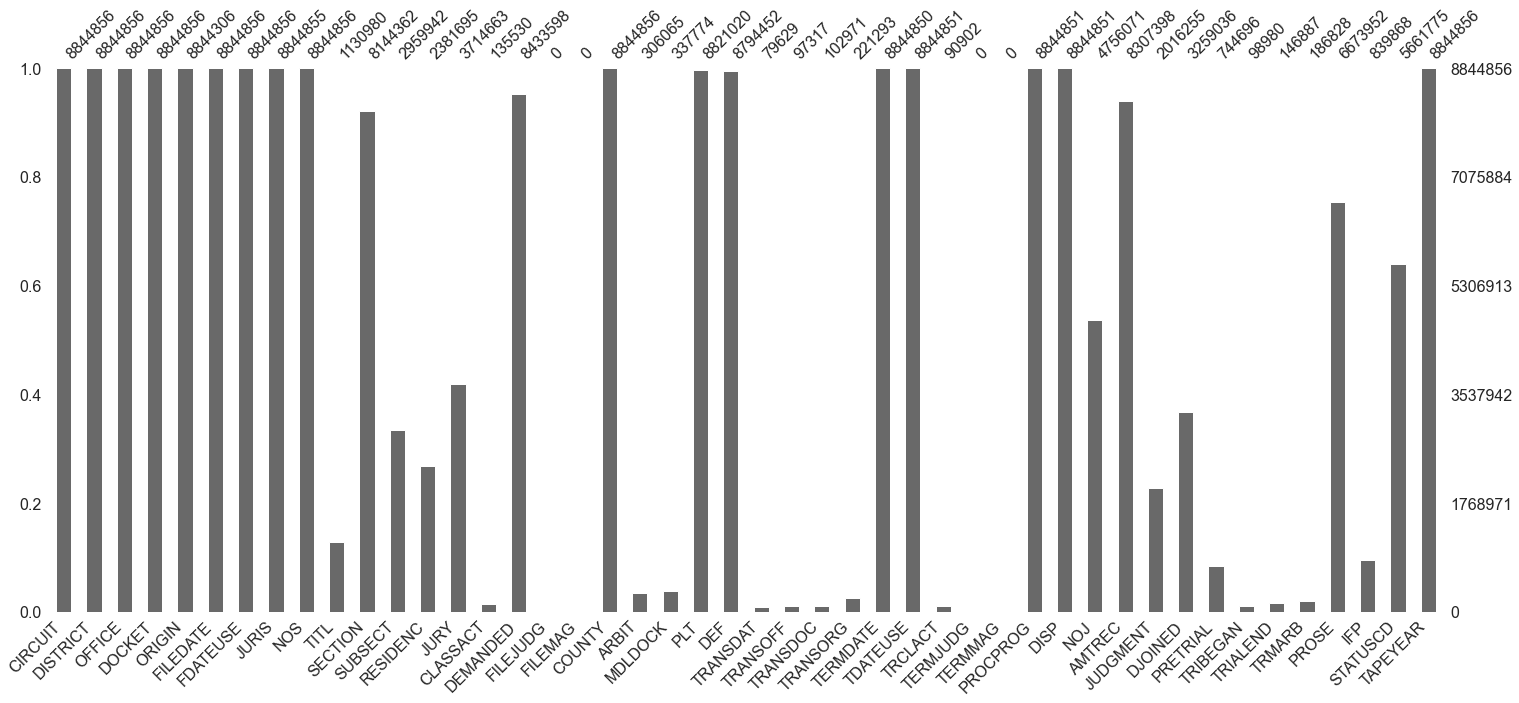

In [13]:
msno.bar(df)

## *The above bar graph shows that a lot of columns have almost all data is missing*


---



2.4.1.2 Heat Map for missing value correlation


*   The heatmap is used to identify correlations of the nullity between each of the different columns. In other words, it can be used to identify if there is a relationship in the presence of null values between each of the columns.
Values close to positive 1 indicate that the presence of null values in one column is correlated with the presence of null values in another column.
Values close to negative 1 indicate that the presence of null values in one column is anti-correlated with the presence of null values in another column. In other words, when null values are present in one column, there are data values present in the other column, and vice versa.
Values close to 0, indicate there is little to no relationship between the presence of null values in one column compared to another.
There are a number of values that show as <-1. This indicates that the correlation is very close to being 100% negative.



<AxesSubplot:>

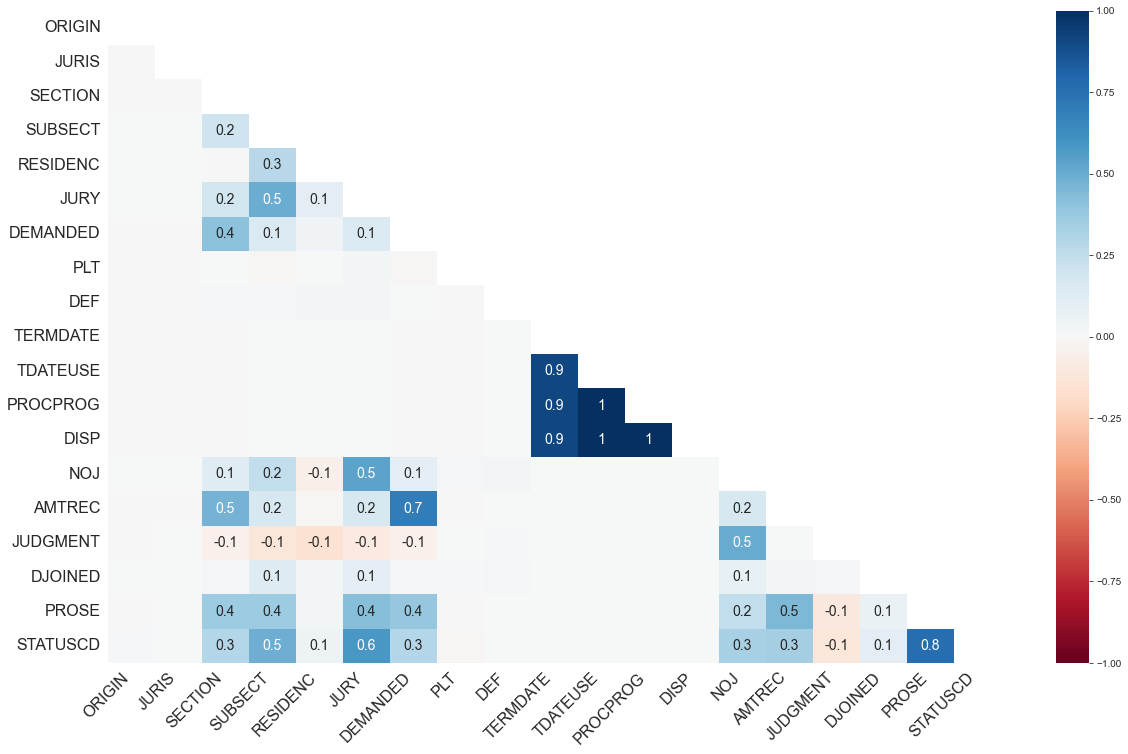

In [16]:
msno.heatmap(df)

## Heatmap shows correlation of missing values in:

1.   PROCPROG & TDATEUSE
2.   DISP & TDATEUSE
3.   DISP & PROCPROG


---




2.4.1.3 Matrix

*   Matrix graph in our case would help us to visualize how data is collected throughout the years



<AxesSubplot:>

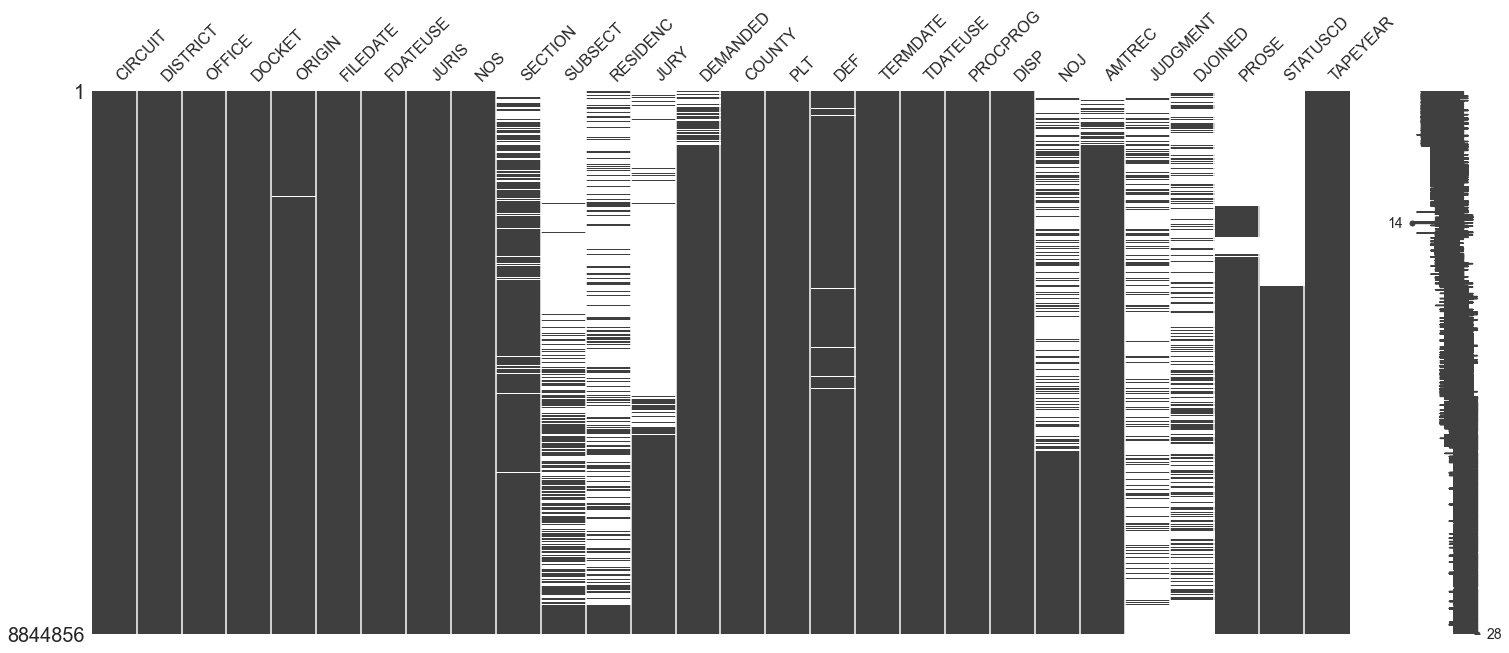

In [17]:
msno.matrix(df)

## Matrix graph facts:


*   List item
*   List item



## 2.4.2 Dropping missing values


*   Dropping columns who do not have atleast 20% of data



In [14]:
print("Old Shape:",df.shape)
threshold = len(df)*0.20
print("Removing columnns which do not have atleast", round(threshold/len(df)*100),"% percent datapoints.")
df.dropna(axis=1,thresh=threshold,inplace=True)
#df = df.dropna(how='any',axis=0)
print("New Shape:",df.shape)

Old Shape: (8844856, 46)
Removing columnns which do not have atleast 20 % percent datapoints.
New Shape: (8844856, 28)




*   Function for missing values table



In [15]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 28 columns and 8844856 Rows.
There are 19 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
JUDGMENT,0,6828601,77.2,6828601,77.2,float64
RESIDENC,23,6463161,73.1,6463184,73.1,float64
SUBSECT,0,5884914,66.5,5884914,66.5,object
DJOINED,0,5585820,63.2,5585820,63.2,object
JURY,0,5130193,58.0,5130193,58.0,object
NOJ,4128472,4088785,46.2,8217257,92.9,float64
STATUSCD,0,3183081,36.0,3183081,36.0,object
PROSE,4787819,2170904,24.5,6958723,78.7,float64
SECTION,0,700494,7.9,700494,7.9,object
AMTREC,7848526,537458,6.1,8385984,94.8,float64


<AxesSubplot:>

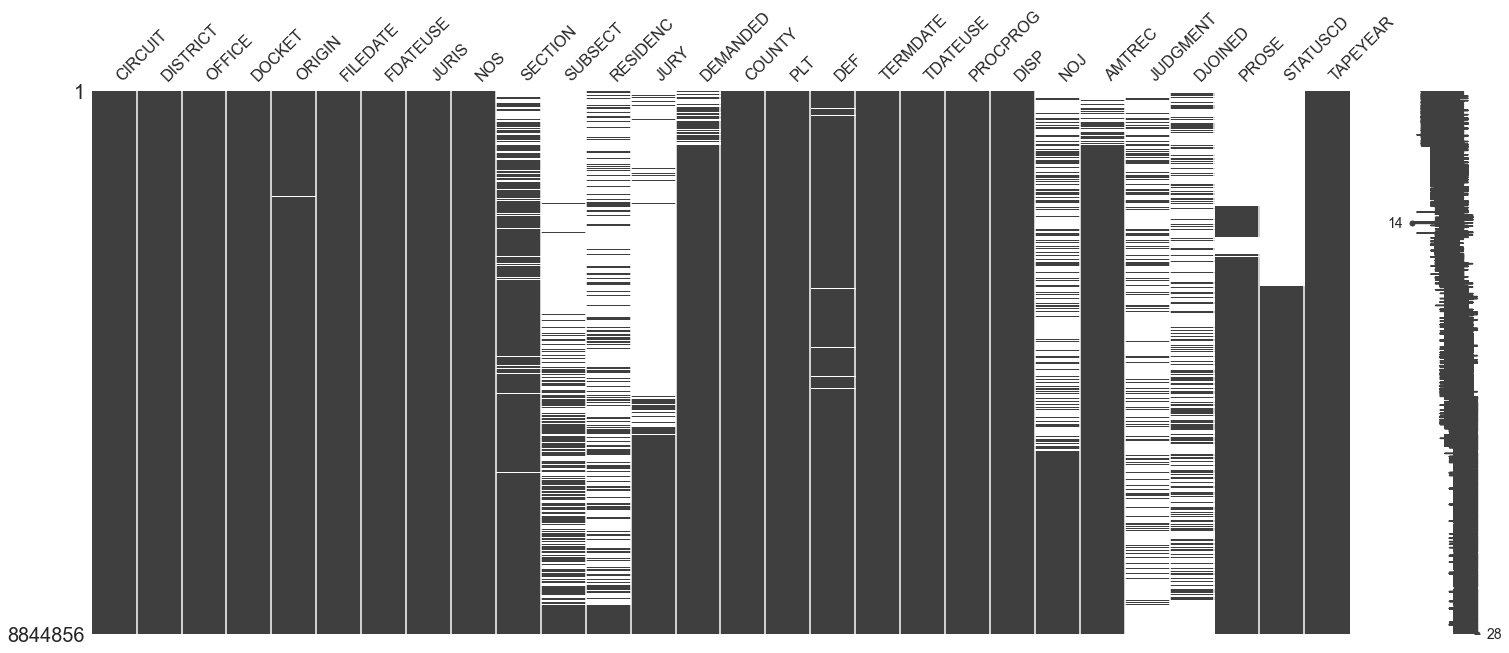

In [18]:
msno.matrix(df)

### 2.4.2.2 Dropping non-useful rows and columns
* where STATUSCD, PLT & DEF are missing
* because a negligible number of rows from all above columns are missing i.e. dropping the rows won't affect the dataset



1.   **STATUSCD:** Only one half of dataset has information about status of record (Pending/Terminated)
2.   **PLT** & **DEF**: Very small missing value number






Old Shape: (8844856, 28)
New Shape: (5612112, 28)


<AxesSubplot:>

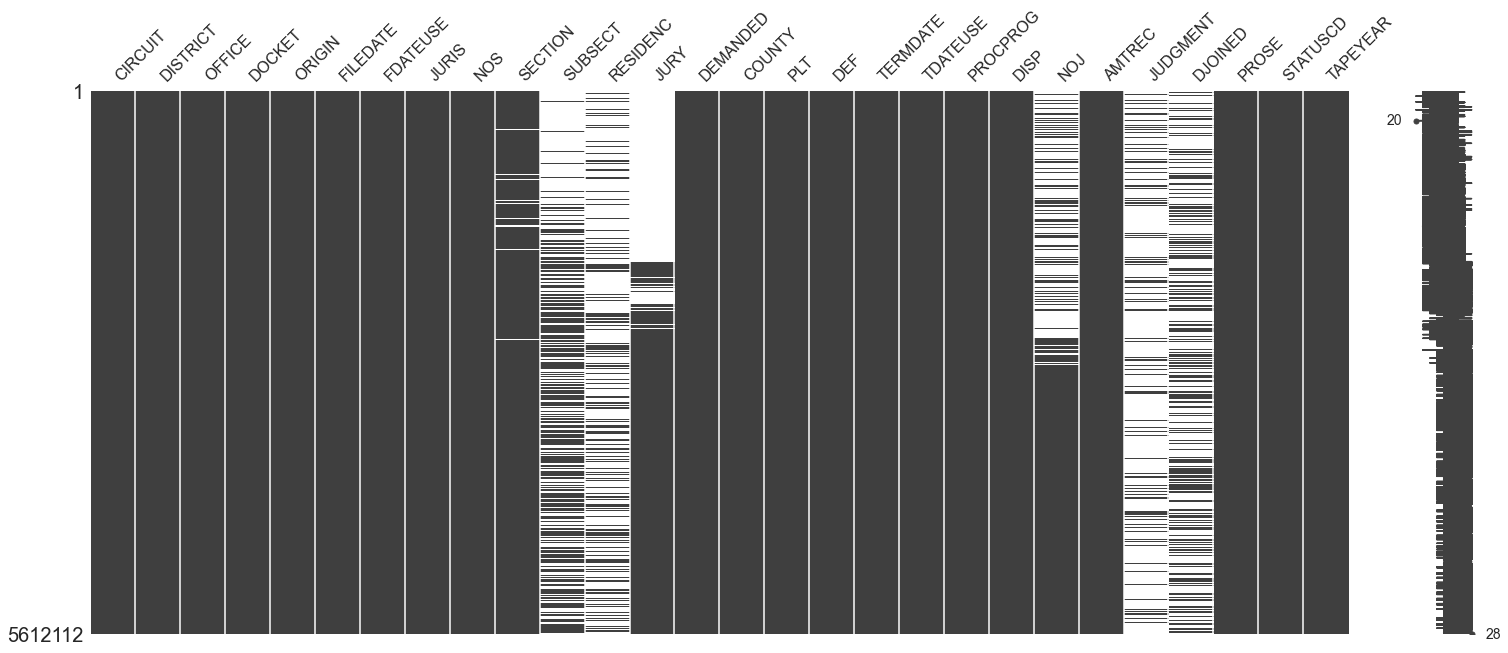

In [20]:
print("Old Shape:",df.shape)
df.dropna(subset=["STATUSCD","PLT","DEF"],inplace=True)
print("New Shape:",df.shape)
msno.matrix(df)

Dropping other non useful columns

<AxesSubplot:>

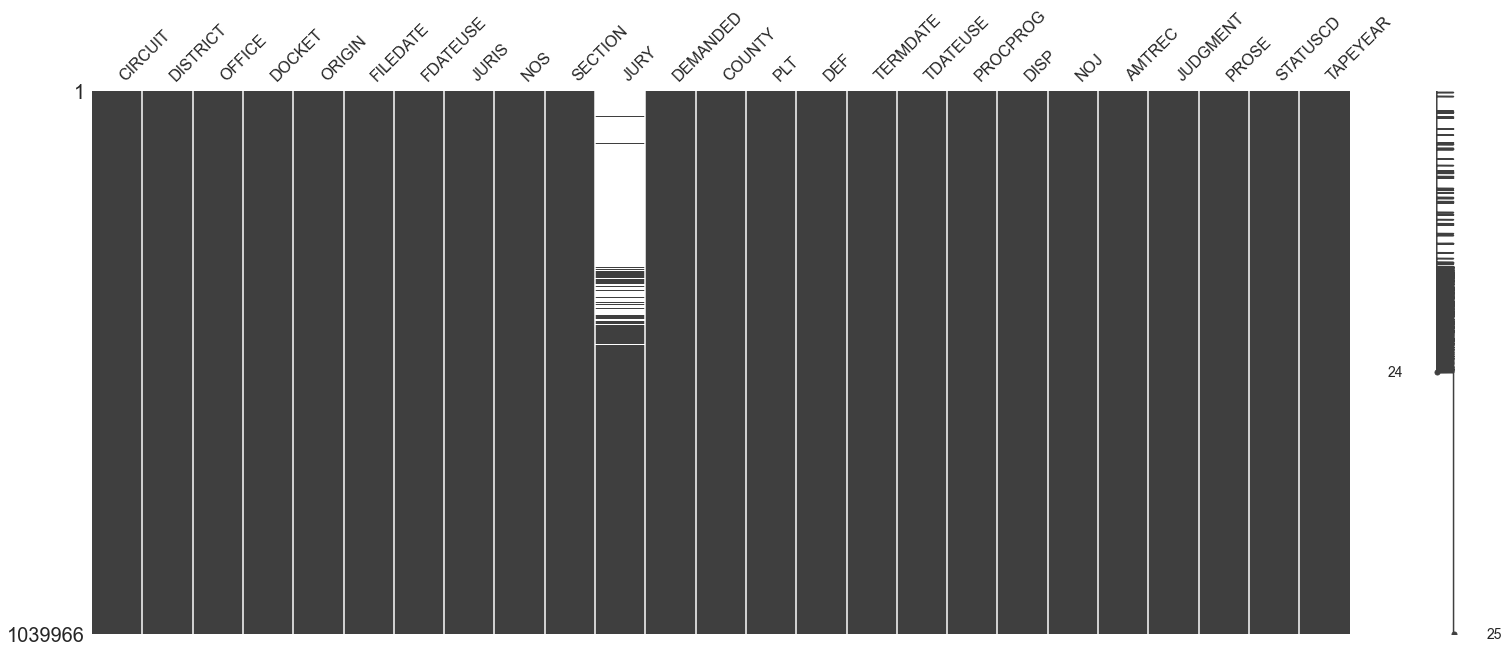

In [28]:
df= df.drop(columns=["DJOINED","SUBSECT","RESIDENC"])
msno.matrix(df)

<AxesSubplot:>

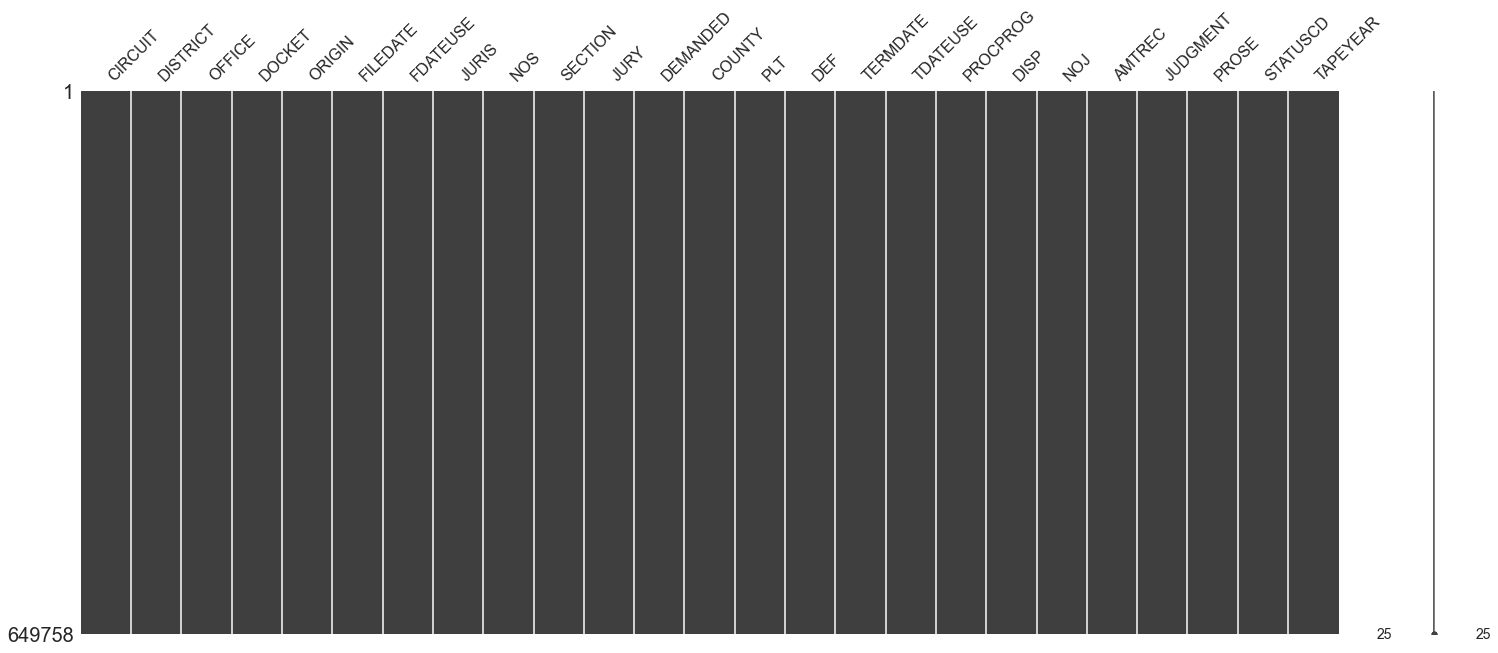

In [29]:
df.dropna(subset=["NOJ","JUDGMENT","PROSE","STATUSCD","SECTION","PLT","DEF","JURY"],inplace=True)
msno.matrix(df)

In [30]:
missing_zero_values_table(df)

Your selected dataframe has 25 columns and 649758 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


## Imputation

In [24]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,SECTION,...,TERMDATE,TDATEUSE,PROCPROG,DISP,NOJ,AMTREC,JUDGMENT,PROSE,STATUSCD,TAPEYEAR
3183092,0,90,1,43,1.0,01/07/2000,01/01/2000,3.0,740,0151,...,03/28/2001,03/01/2001,4.0,6.0,0.0,0.0,1.0,0.0,L,2001
3183095,0,90,1,66,1.0,01/11/2000,01/01/2000,2.0,893,0551,...,03/30/2001,03/01/2001,4.0,17.0,0.0,0.0,3.0,0.0,L,2001
3183099,0,90,1,73,1.0,01/12/2000,01/01/2000,2.0,890,1395,...,06/06/2001,06/01/2001,4.0,6.0,0.0,0.0,1.0,0.0,L,2001
3183100,0,90,1,74,1.0,01/12/2000,01/01/2000,3.0,442,2003,...,10/20/2000,10/01/2000,5.0,6.0,0.0,0.0,2.0,2.0,L,2001
3183104,0,90,1,79,1.0,01/13/2000,01/01/2000,2.0,863,0405,...,10/03/2000,10/01/2000,4.0,6.0,0.0,0.0,2.0,0.0,L,2001


In [27]:
get_column_stats("JURY")

Number of NaN: 390208
Percentage of NaN: 37.52 %
Number of Unique Values:  5 

Unique Values:  [nan 'P' 'N' 'Y' 'D' 'B'] 

Description of Column:
 count         5.000000
mean     129951.600000
std      164865.560659
min           5.000000
25%       30558.000000
50%       51992.000000
75%      163887.000000
max      403316.000000
Name: JURY, dtype: float64

Top  Value Count:  
 N    403316
P    163887
B     51992
D     30558
Y         5
Name: JURY, dtype: int64

|  25% of JURY column's data appear in 30558 rows at most 

|  50% of JURY column's data appear in 51992 rows at most 


## 2.5 Feature Engineering


2.5.1. **LABEL_C:** 
Creating a new column called "LABEL_C" which is the combination of **NOJ** and **JUDGMENT**


*   Consists of 2-digit code
*   First(unit) represents nature of Judgement
*   Second(tens) represents Judgment in favour of
*   Will be only used for Model 3.





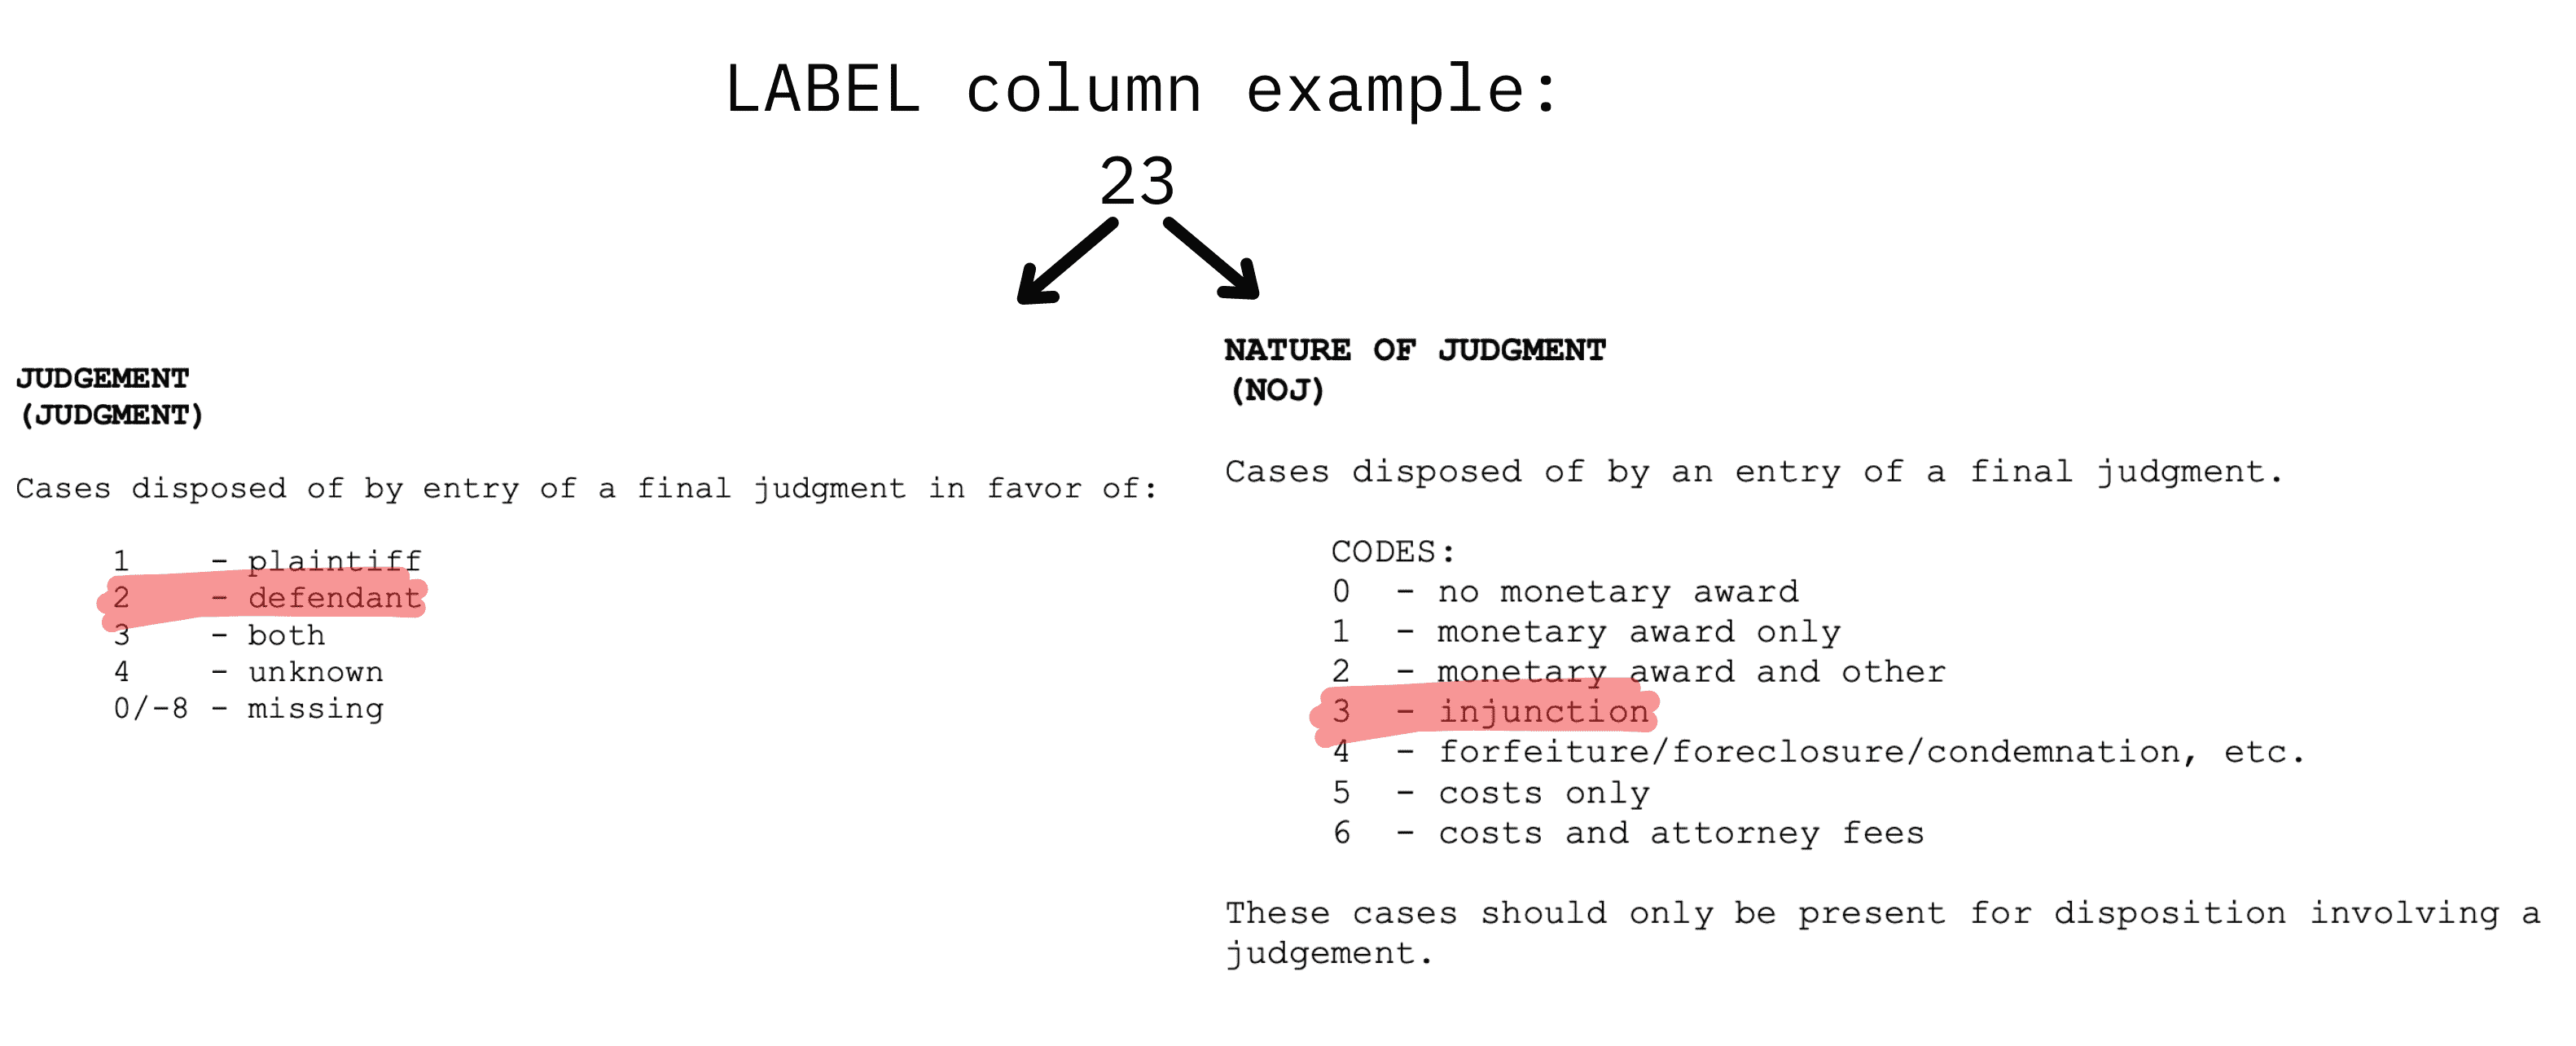

In [31]:
df["LABEL_C"] = df["NOJ"] + (df["JUDGMENT"]*10)
#to_drop = ['NOJ','JUDGMENT']
#df.drop(to_drop, inplace=True,axis=1)
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,SECTION,...,TDATEUSE,PROCPROG,DISP,NOJ,AMTREC,JUDGMENT,PROSE,STATUSCD,TAPEYEAR,LABEL_C
3196641,2,06,5,9100793,1.0,07/12/1991,07/01/1991,3.0,893,6901,...,03/01/2001,9.0,5.0,2.0,3700.0,1.0,0.0,L,2001,12.0
3197433,2,06,9,8901325,4.0,11/02/1989,11/01/1989,3.0,550,1983,...,01/01/2001,4.0,6.0,0.0,0.0,2.0,1.0,L,2001,20.0
3223818,3,12,2,9903964,1.0,08/20/1999,08/01/1999,3.0,440,1983,...,11/01/2000,12.0,6.0,0.0,0.0,3.0,0.0,L,2001,30.0
3341918,8,65,4,9102480,1.0,12/10/1991,12/01/1991,1.0,850,77QA,...,11/01/2000,8.0,9.0,5.0,0.0,1.0,2.0,L,2001,15.0
3341925,8,65,4,9601042,1.0,05/22/1996,05/01/1996,3.0,442,2000,...,05/01/2001,10.0,5.0,2.0,185.0,1.0,0.0,L,2001,12.0


2.5.2 **CASEDAYS:** Creating a new column, calculating days it take to process a case


*   Converting FILDATE & TERMDATE into datetime format
*   Substracting to get the total number of days



In [32]:
df["TERMDATE"]= pd.to_datetime(df["TERMDATE"])
df["FILEDATE"]= pd.to_datetime(df["FILEDATE"])
df["CASEDAYS"] = (df["TERMDATE"]-df["FILEDATE"]).dt.days
to_drop = ['TERMDATE','FILEDATE','FDATEUSE']
df.drop(to_drop, inplace=True,axis=1)
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,JURIS,NOS,SECTION,JURY,DEMANDED,...,PROCPROG,DISP,NOJ,AMTREC,JUDGMENT,PROSE,STATUSCD,TAPEYEAR,LABEL_C,CASEDAYS
3196641,2,06,5,9100793,1.0,3.0,893,6901,P,0.0,...,9.0,5.0,2.0,3700.0,1.0,0.0,L,2001,12.0,3548
3197433,2,06,9,8901325,4.0,3.0,550,1983,P,9999.0,...,4.0,6.0,0.0,0.0,2.0,1.0,L,2001,20.0,4080
3223818,3,12,2,9903964,1.0,3.0,440,1983,P,0.0,...,12.0,6.0,0.0,0.0,3.0,0.0,L,2001,30.0,453
3341918,8,65,4,9102480,1.0,1.0,850,77QA,N,0.0,...,8.0,9.0,5.0,0.0,1.0,2.0,L,2001,15.0,3256
3341925,8,65,4,9601042,1.0,3.0,442,2000,Y,250.0,...,10.0,5.0,2.0,185.0,1.0,0.0,L,2001,12.0,1834


2.5.3 **PLT_ETAL & DEF_ETAL:** Flag if Plantiff/Defendent is filing with other individuals or parties i.e. 
*   0 if filing alone
*   1 if filing with others

PLT & DEF column contains names of Plantiff and Defendent as well as ETAL info. "ET AL" & "ETAL" is added at the end of every data point with ETAL.





In [33]:
df["PLT_ETAL"] = df["PLT"].str.contains("ETAL|ET AL")
df["DEF_ETAL"] = df["DEF"].str.contains("ETAL|ET AL")

In [34]:
df["PLT"].info()

<class 'pandas.core.series.Series'>
Int64Index: 649758 entries, 3196641 to 9474367
Series name: PLT
Non-Null Count   Dtype 
--------------   ----- 
649758 non-null  object
dtypes: object(1)
memory usage: 9.9+ MB


2.5.4 **DISTRICT:** This column contains some values which are not ***int***. Therefore, replacing them.


*   Although it is not required because it is a categorical feature
*   Reference: *Codebook*



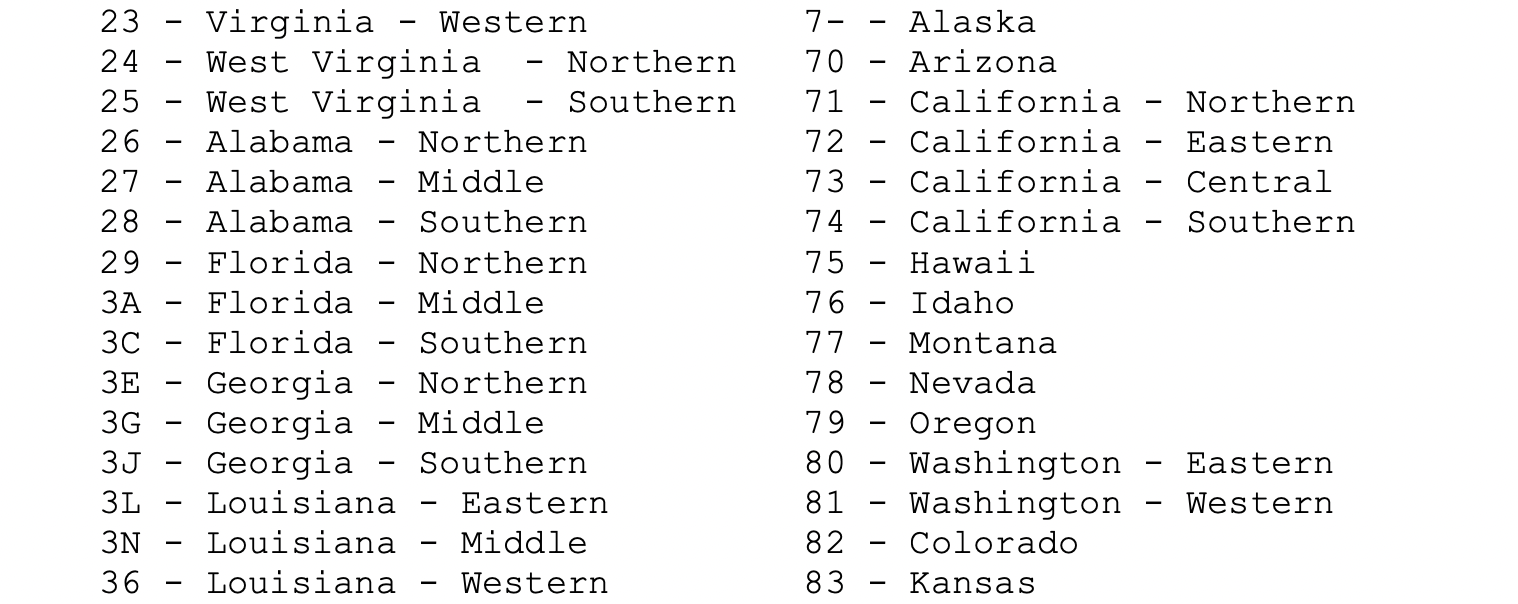

In [35]:
df['DISTRICT'] = df['DISTRICT'].replace(['3A','3C','3E','3G','3J','3L','3N','7-'],['30','31','32','33','34','35','96','95'])
df["DISTRICT"] = df["DISTRICT"].astype(int)

## 2.6 Feature Engineering using NLP
*   PLT & DEF data can be used to extract their name entities. For example, if it is an Organization, Person, Location etc.
*   ***spacy*** offers NER for following entities:

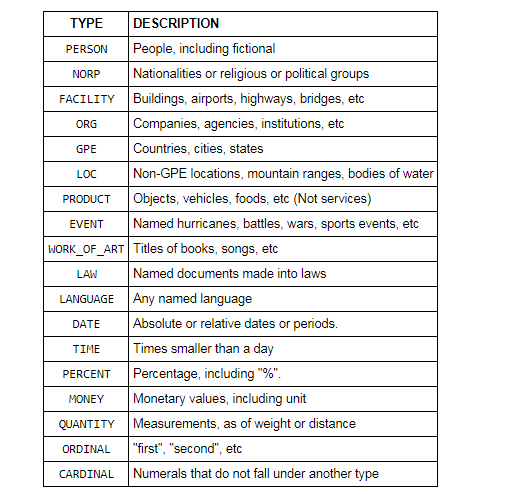

### Lets analyze PLT & DEF columns:

In [60]:
def plot_topn_vcounts(dataframe,column,n):
    count = dataframe[column].value_counts()
    count = count[:n,]
    plt.figure(figsize=(20,10))
    ax = sns.barplot(count.index,count.values,alpha=0.8)
    plt.title("Top "+str(n)+' '+str(column))
    plt.ylabel("Count")
    plt.xlabel("Plantiff")
    plt.setp(ax.get_xticklabels(),rotation=45)
    return plt.show

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

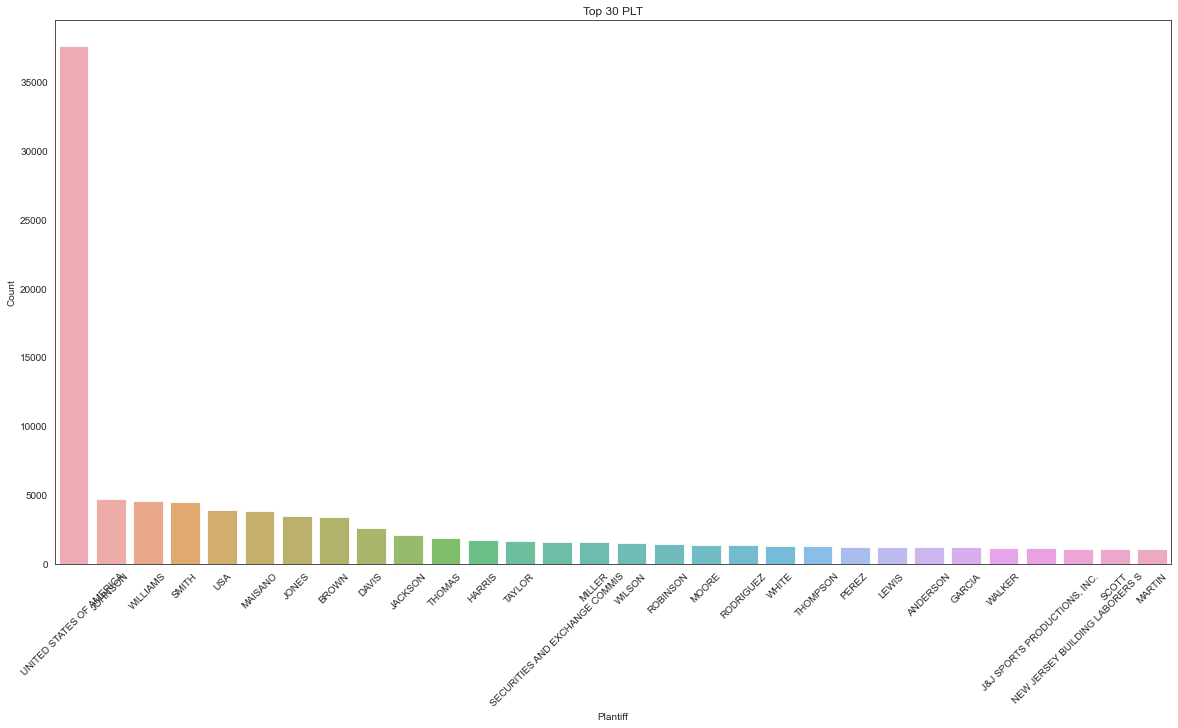

In [61]:
plot_topn_vcounts(df,"PLT",30)

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

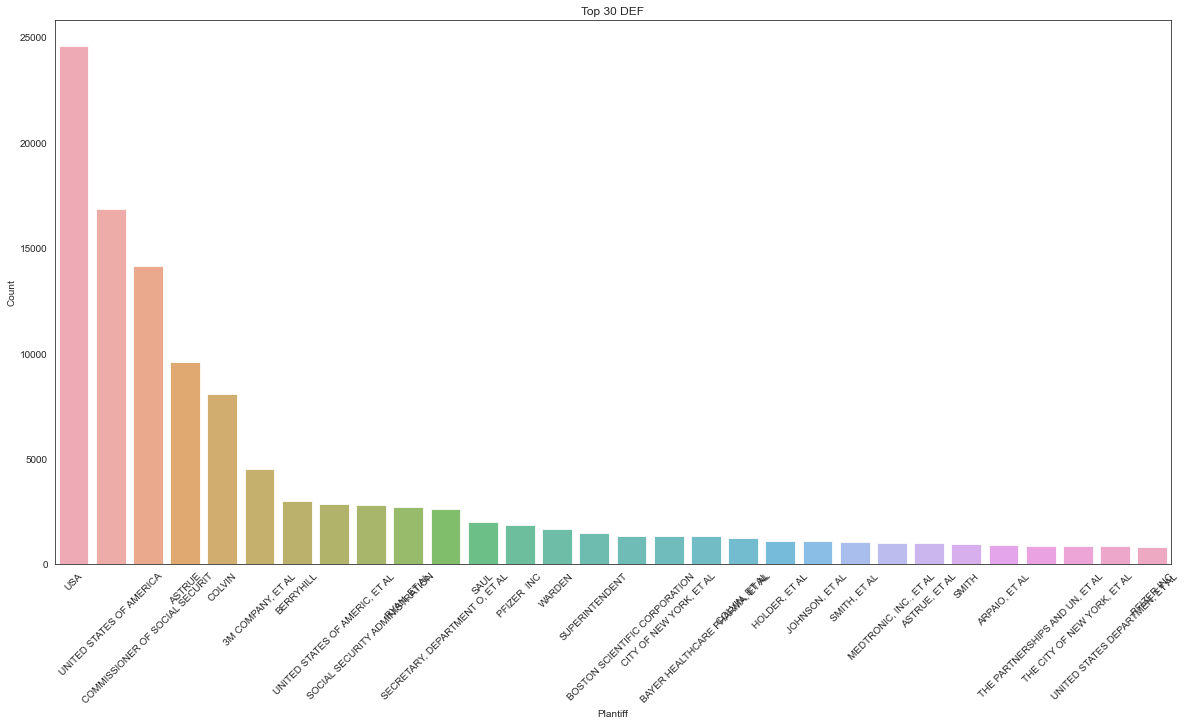

In [62]:
plot_topn_vcounts(df,"DEF",30)

#Remove ET AL string

In [63]:
df["PLT"] = df["PLT"].str.replace("ET AL","")
df["DEF"] = df["DEF"].str.replace("ET AL","")

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

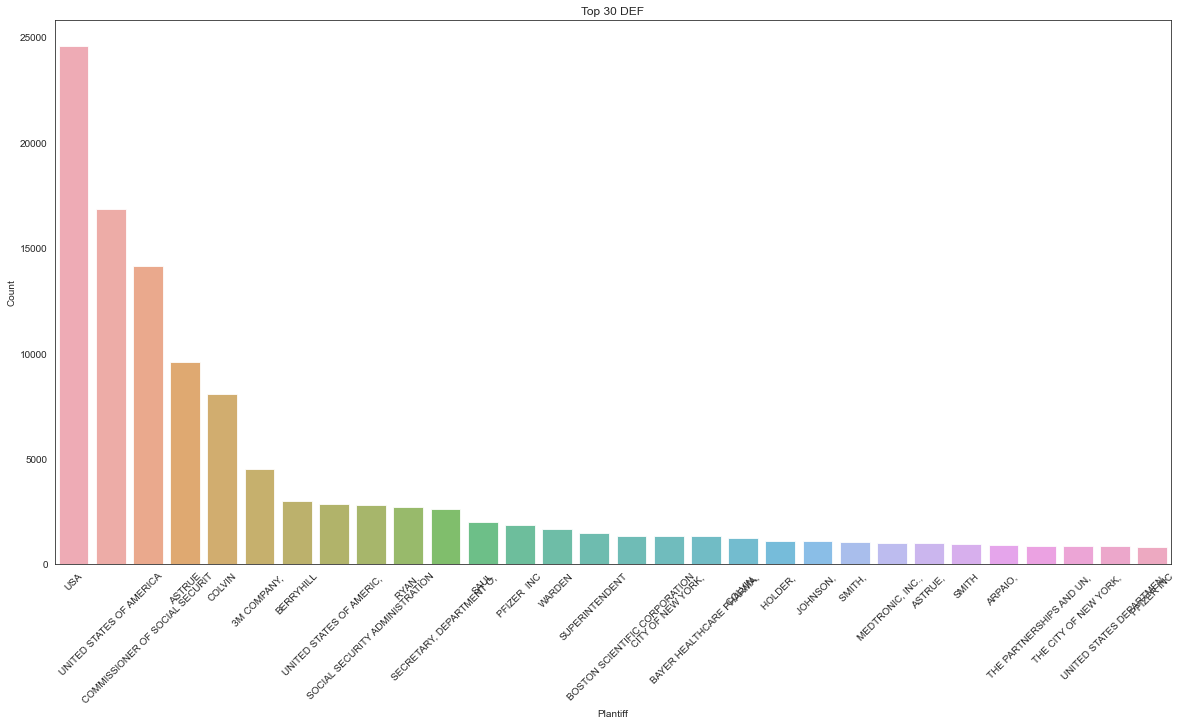

In [66]:
plot_topn_vcounts(df,"DEF",30)

In [39]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,JURIS,NOS,SECTION,JURY,DEMANDED,...,NOJ,AMTREC,JUDGMENT,PROSE,STATUSCD,TAPEYEAR,LABEL_C,CASEDAYS,PLT_ETAL,DEF_ETAL
3196641,2,6,5,9100793,1.0,3.0,893,6901,P,0.0,...,2.0,3700.0,1.0,0.0,L,2001,12.0,3548,False,False
3197433,2,6,9,8901325,4.0,3.0,550,1983,P,9999.0,...,0.0,0.0,2.0,1.0,L,2001,20.0,4080,False,False
3223818,3,12,2,9903964,1.0,3.0,440,1983,P,0.0,...,0.0,0.0,3.0,0.0,L,2001,30.0,453,False,False
3341918,8,65,4,9102480,1.0,1.0,850,77QA,N,0.0,...,5.0,0.0,1.0,2.0,L,2001,15.0,3256,False,False
3341925,8,65,4,9601042,1.0,3.0,442,2000,Y,250.0,...,2.0,185.0,1.0,0.0,L,2001,12.0,1834,False,False


Cleaning PLantiff and Defendent columns:

In [67]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
vals = df['PLT'].unique().astype('U')
vals

array(['ITT COMMERCIAL', 'JERMOSEN', 'SUVAROV', ..., 'JARJOUR', 'TWILLIE',
       'MONITRONICS INTERNATIONAL INC.'], dtype='<U30')

In [ ]:
# Write a function for cleaning strings and returning an array of ngrams
def ngrams_analyzer(string):
    string = re.sub(r'[,-./]', r'', string)
    ngrams = zip(*[string[i:] for i in range(5)])  # N-Gram length is 5
    return [''.join(ngram) for ngram in ngrams]

# Construct your vectorizer for building the TF-IDF matrix
vectorizer = TfidfVectorizer(analyzer=ngrams_analyzer)

# Build the matrix!!!
tfidf_matrix = vectorizer.fit_transform(vals)


In [38]:
nlp = spacy.load('en_core_web_sm', disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

def get_orgs(doc):
    org_list = []
    for entity in doc.ents:
        if entity.label_ == 'ORG':
            org_list.append(entity.text)
    # if organization is identified more than once it will appear multiple times in list
    # set() to remove duplicates then convert back to list
    org_list = list(set(org_list))
    return org_list 

def preprocess_pipe_org(text):
    preproc_pipe_org = []
    for doc in nlp.pipe(text, batch_size=100000, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        preproc_pipe_org.append(get_orgs(doc))
    return preproc_pipe_org

In [46]:
def get_person(doc):
    person_list = []
    for entity in doc.ents:
        if entity.label_ == 'PERSON':
            person_list.append(entity.text)
    # if person is identified more than once it will appear multiple times in list
    # set() to remove duplicates then convert back to list
    person_list = list(set(person_list))
    return person_list 

def preprocess_pipe_person(text):
    preproc_pipe_person = []
    for doc in nlp.pipe(text, batch_size=100000, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        preproc_pipe_person.append(get_person(doc))
    return preproc_pipe_person

In [49]:
def get_gpe(doc):
    gpe_list = []
    for entity in doc.ents:
        if entity.label_ == 'GPE':
            gpe_list.append(entity.text)
    # if gpe is identified more than once it will appear multiple times in list
    # set() to remove duplicates then convert back to list
    gpe_list = list(set(gpe_list))
    return gpe_list 

def preprocess_pipe_gpe(text):
    preproc_pipe_gpe = []
    for doc in nlp.pipe(text, batch_size=100000, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        preproc_pipe_gpe.append(get_gpe(doc))
    return preproc_pipe_gpe

In [41]:
df["PLT_ORG"] = preprocess_pipe_org(df['PLT'])
df["DEF_ORG"] = preprocess_pipe_org(df['DEF'])

In [47]:
df["PLT_PERSON"] = preprocess_pipe_person(df['PLT'])
df["DEF_PERSON"] = preprocess_pipe_person(df['DEF'])

In [50]:
df["PLT_GPE"] = preprocess_pipe_gpe(df['PLT'])
df["DEF_GPE"] = preprocess_pipe_gpe(df['DEF'])

*    If **PLT/DEF** is an organisation, **PLT_ORG/DEF_ORG** will have the name of the organisation(s)
*    Similarly, for entities i.e. PERSON, GPE, NORP

TODO: PLACE PLT VS PLT_ORG HERE

In [52]:
def remove_brackets_from_column(columns):
  for cols in columns:
    df[cols] = df[cols].str[0]

remove_brackets_from_column(['PLT_ORG','DEF_ORG','PLT_PERSON','DEF_PERSON','PLT_GPE','DEF_GPE'])

In [54]:
df.head(10)

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,JURIS,NOS,RESIDENC,JURY,DEMANDED,...,LABEL_C,CASEDAYS,PLT_ETAL,DEF_ETAL,PLT_ORG,DEF_ORG,PLT_PERSON,DEF_PERSON,PLT_GPE,DEF_GPE
3183092,0,90,1,43,1.0,3.0,740,NaN,NaN,0.0,...,10.0,446,True,True,ET AL,ET AL,NaN,NaN,NaN,NaN
3183095,0,90,1,66,1.0,2.0,893,NaN,NaN,0.0,...,30.0,444,True,True,CITY/WILLIAMS,ET AL,NaN,NaN,NaN,NaN
3183099,0,90,1,73,1.0,2.0,890,NaN,NaN,0.0,...,10.0,511,True,False,ET AL,SHALALA,NaN,NaN,NaN,NaN
3183100,0,90,1,74,1.0,3.0,442,NaN,NaN,2000.0,...,20.0,282,False,True,DAVIS,SECURIT,NaN,NaN,NaN,NaN
3183104,0,90,1,79,1.0,2.0,863,NaN,NaN,0.0,...,20.0,264,False,False,NaN,NaN,NaN,NaN,NaN,NaN
3183105,0,90,1,82,1.0,3.0,442,NaN,NaN,300.0,...,20.0,350,False,False,BATTLE,WMATA,NaN,NaN,NaN,NaN
3183106,0,90,1,103,1.0,3.0,555,NaN,NaN,0.0,...,20.0,560,False,True,GLOVER,ET AL,NaN,NaN,NaN,WASHINGTON
3183108,0,90,1,105,1.0,2.0,550,NaN,NaN,0.0,...,20.0,618,False,False,RUIZ,NaN,NaN,NaN,NaN,NaN
3183109,0,90,1,108,1.0,3.0,555,NaN,NaN,750.0,...,20.0,505,False,True,GLOVER,ET AL,NaN,NaN,NaN,WASHINGTON
3183113,0,90,1,115,1.0,2.0,442,NaN,NaN,300.0,...,10.0,436,False,False,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
df_nlp = df[['PLT','DEF','PLT_ORG','DEF_ORG','PLT_PERSON','DEF_PERSON','PLT_GPE','DEF_GPE']]
df_nlp.head(20)

,PLT,DEF,PLT_ORG,DEF_ORG,PLT_PERSON,DEF_PERSON,PLT_GPE,DEF_GPE
3183092,"GENERAL COMM/ADJUST, ET AL","BURLINGTON NORTHERN, ET AL",,,NaN,NaN,NaN,NaN
3183095,"CITY/WILLIAMS, ARIZO, ET AL","DOMBECK, ET AL",CITY/WILLIAMS,,NaN,NaN,NaN,NaN
3183099,"LOS ANGELES CO/DHS, ET AL",SHALALA,,SHALALA,NaN,NaN,NaN,NaN
3183100,DAVIS,"COASTAL INTL SECURIT, ET AL",DAVIS,SECURIT,NaN,NaN,NaN,NaN
3183104,YOUNG,APFEL,NaN,NaN,NaN,NaN,NaN,NaN
3183105,BATTLE,WMATA,BATTLE,WMATA,NaN,NaN,NaN,NaN
3183106,GLOVER,"WASHINGTON, ET AL",GLOVER,,NaN,NaN,NaN,WASHINGTON
3183108,RUIZ,DOJ,RUIZ,NaN,NaN,NaN,NaN,NaN
3183109,GLOVER,"WASHINGTON, ET AL",GLOVER,,NaN,NaN,NaN,WASHINGTON
3183113,BASS,TANOUE,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df["PLT_ORG"] = df["PLT_ORG"].str.replace('ET AL','')
df["DEF_ORG"] = df["DEF_ORG"].str.replace('ET AL','')

In [65]:
df["PLT_ORG_FLAG"] = df["PLT_ORG"].str.len() > 0
df["DEF_ORG_FLAG"] = df["DEF_ORG"].str.len() > 0

df["PLT_GPE_FLAG"] = df["PLT_GPE"].str.len() > 0
df["DEF_GPE_FLAG"] = df["DEF_GPE"].str.len() > 0

In [66]:
df.head(40)

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,JURIS,NOS,RESIDENC,JURY,DEMANDED,...,PLT_ORG,DEF_ORG,PLT_PERSON,DEF_PERSON,PLT_GPE,DEF_GPE,PLT_ORG_FLAG,DEF_ORG_FLAG,PLT_GPE_FLAG,DEF_GPE_FLAG
3183092,0,90,1,43,1.0,3.0,740,NaN,NaN,0.0,...,,,NaN,NaN,NaN,NaN,False,False,False,False
3183095,0,90,1,66,1.0,2.0,893,NaN,NaN,0.0,...,CITY/WILLIAMS,,NaN,NaN,NaN,NaN,True,False,False,False
3183099,0,90,1,73,1.0,2.0,890,NaN,NaN,0.0,...,,SHALALA,NaN,NaN,NaN,NaN,False,True,False,False
3183100,0,90,1,74,1.0,3.0,442,NaN,NaN,2000.0,...,DAVIS,SECURIT,NaN,NaN,NaN,NaN,True,True,False,False
3183104,0,90,1,79,1.0,2.0,863,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
3183105,0,90,1,82,1.0,3.0,442,NaN,NaN,300.0,...,BATTLE,WMATA,NaN,NaN,NaN,NaN,True,True,False,False
3183106,0,90,1,103,1.0,3.0,555,NaN,NaN,0.0,...,GLOVER,,NaN,NaN,NaN,WASHINGTON,True,False,False,True
3183108,0,90,1,105,1.0,2.0,550,NaN,NaN,0.0,...,RUIZ,NaN,NaN,NaN,NaN,NaN,True,False,False,False
3183109,0,90,1,108,1.0,3.0,555,NaN,NaN,750.0,...,GLOVER,,NaN,NaN,NaN,WASHINGTON,True,False,False,True
3183113,0,90,1,115,1.0,2.0,442,NaN,NaN,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False


In [67]:
df.to_csv("LLcleaned_V2.3.csv", sep='\t',header=True)

In [ ]:
get_column_stats("PLT_ORG")

Number of NaN: 391364
Percentage of NaN: 37.63 %
Number of Unique Values:  109079 

Unique Values:  ['' 'CITY/WILLIAMS' 'LOS ANGELES CO/DHS' ... 'ONE HUNDRED MILES' 'JARJOUR'
 'MONITRONICS INTERNATIONAL INC'] 

Description of Column:
 count    109079.000000
mean          5.946167
std         327.655367
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       88485.000000
Name: PLT_ORG, dtype: float64

Top  Value Count:  
                                  88485
UNITED STATES OF AMERICA         50630
USA                              31480
UNITED STATES                     7920
WILLIAMS                          7662
                                 ...  
ANTHOS                               1
NORTHEASTERN                         1
VAN AUKEN                            1
VACCO                                1
MONITRONICS INTERNATIONAL INC        1
Name: PLT_ORG, Length: 109079, dtype: int64

|  25% of PLT_ORG column's data appear in 1 rows at mos

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070636 entries, 3183092 to 9474367
Data columns (total 36 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   CIRCUIT       1070636 non-null  int8   
 1   DISTRICT      1070636 non-null  int64  
 2   OFFICE        1070636 non-null  object 
 3   DOCKET        1070636 non-null  int32  
 4   ORIGIN        1070636 non-null  float64
 5   JURIS         1070636 non-null  float64
 6   NOS           1070636 non-null  int16  
 7   RESIDENC      154340 non-null   float64
 8   JURY          657412 non-null   object 
 9   DEMANDED      1070636 non-null  float64
 10  COUNTY        1070636 non-null  int32  
 11  PLT           1070636 non-null  object 
 12  DEF           1070636 non-null  object 
 13  TDATEUSE      1070636 non-null  object 
 14  PROCPROG      1070636 non-null  float64
 15  DISP          1070636 non-null  float64
 16  NOJ           1070636 non-null  float64
 17  AMTREC        1070636



---



---


# 3. Modelling

###The three models are:

### **Model 1: Predicting Judgement i.e. in favour of**

### Label:
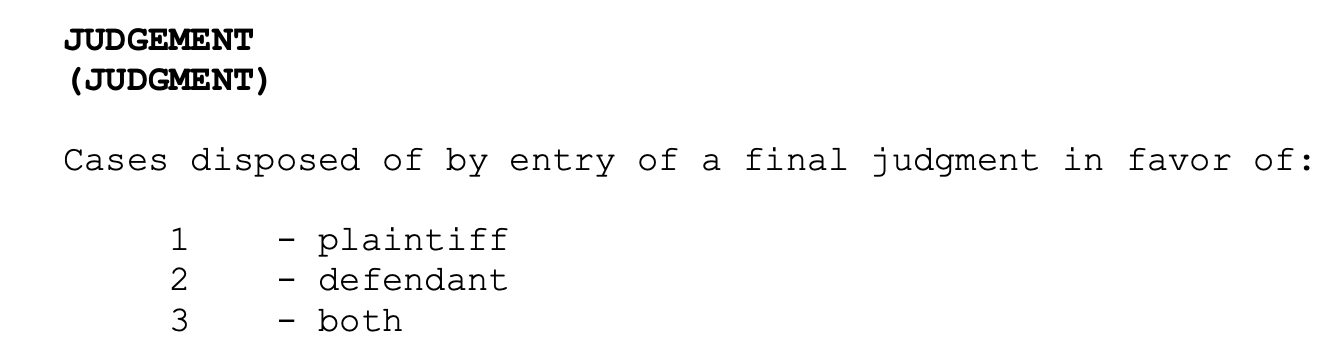




### **Model 2: Prediciting Amount received if case is in favour (Regression)**

### Label:

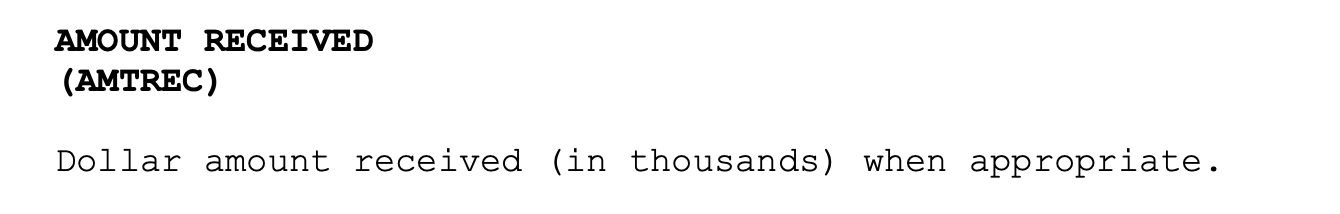


### **Model 3: Predicitng type of case outcome (Classification)**




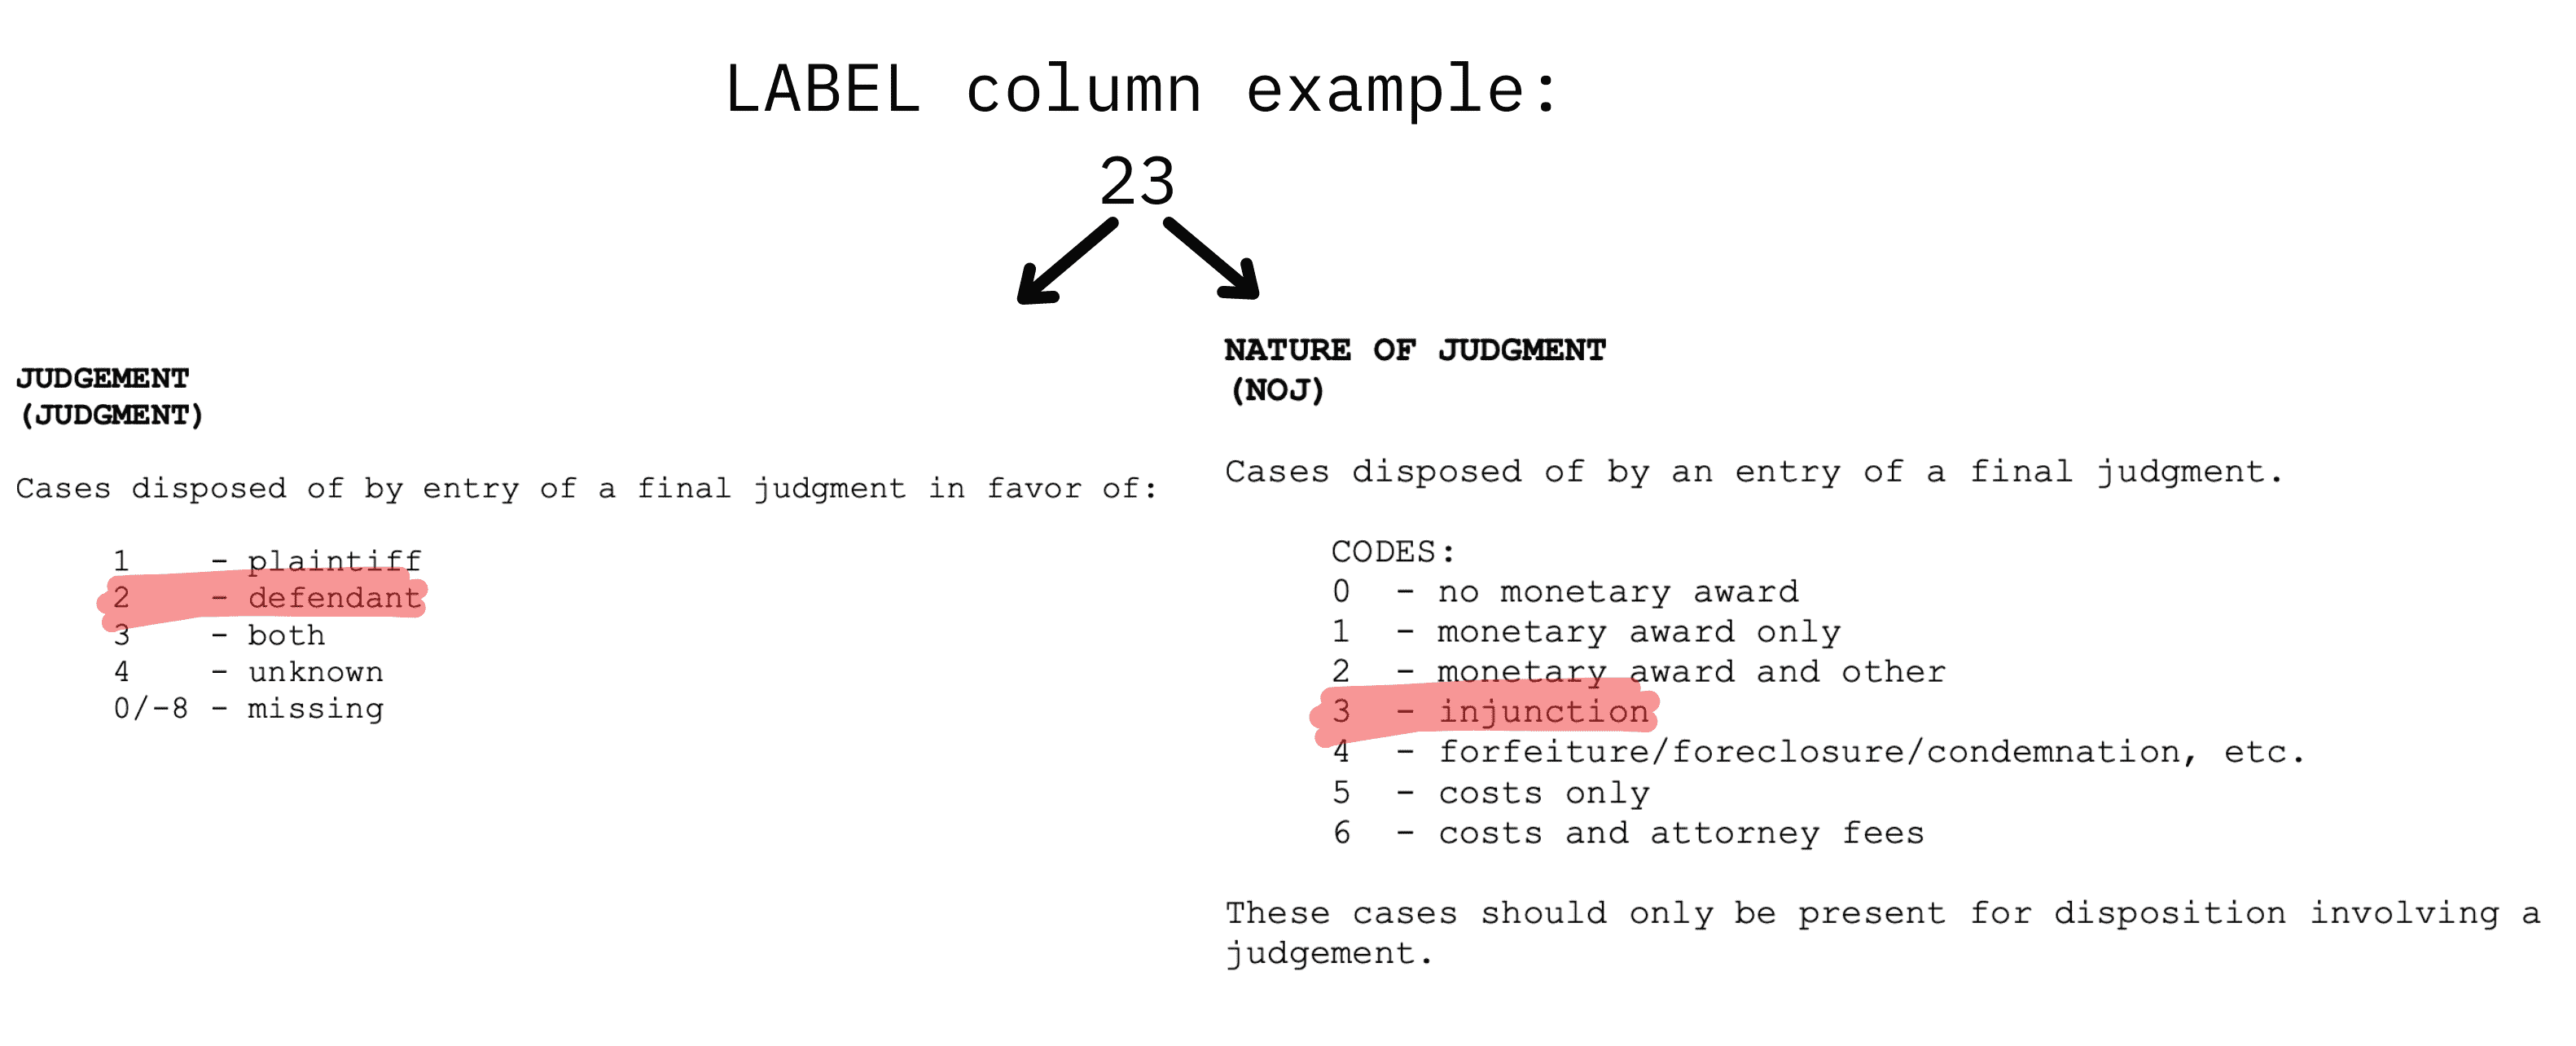







---


## 3.1 Handling Categorical feature





### 3.1.1 Number of unique Values in every catergorical feature


*   It is done to get an approximation of how many new columns would be made after one-hot encoding.

In [70]:
categorical_cols = ['CIRCUIT', 'DISTRICT', 'OFFICE', 'DOCKET','ORIGIN', 'JURIS', 'NOS','JURY','COUNTY','PROCPROG','DISP','PROSE','STATUSCD', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG','PLT_GPE_FLAG','DEF_GPE_FLAG']
df_cat = df[categorical_cols].copy()
df_cat.nunique()

CIRCUIT             12
DISTRICT            94
OFFICE              10
DOCKET          264981
ORIGIN              13
JURIS                5
NOS                107
JURY                 5
COUNTY            3184
PROCPROG            13
DISP                19
PROSE                4
STATUSCD             1
PLT_ETAL             2
DEF_ETAL             2
PLT_ORG_FLAG         2
DEF_ORG_FLAG         2
dtype: int64

# To-do Visualize before dropping



*   DOCKET and COUNTY have very high unique values
*   DOCKET can be dropped because it doesn't contain any useful info.
*   COUNTY can be dropped because we already have geographical location info i.e. DISTRICT



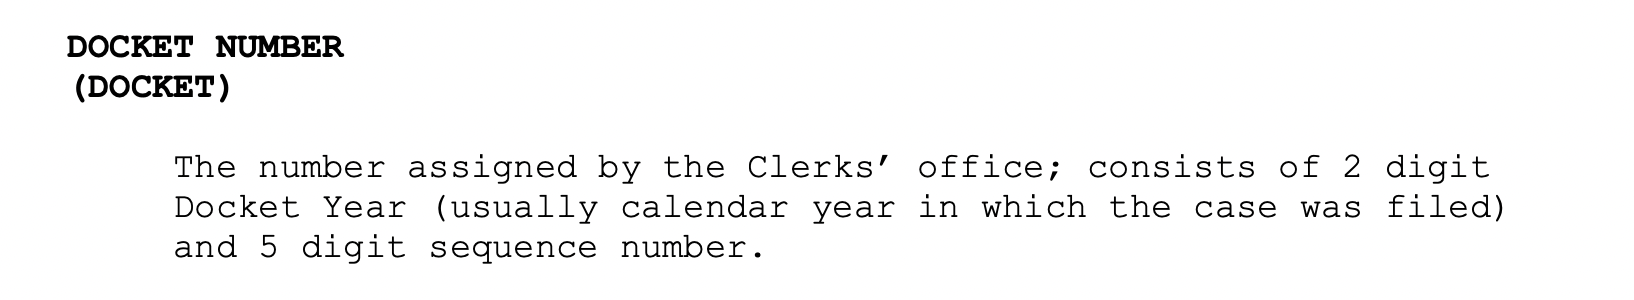

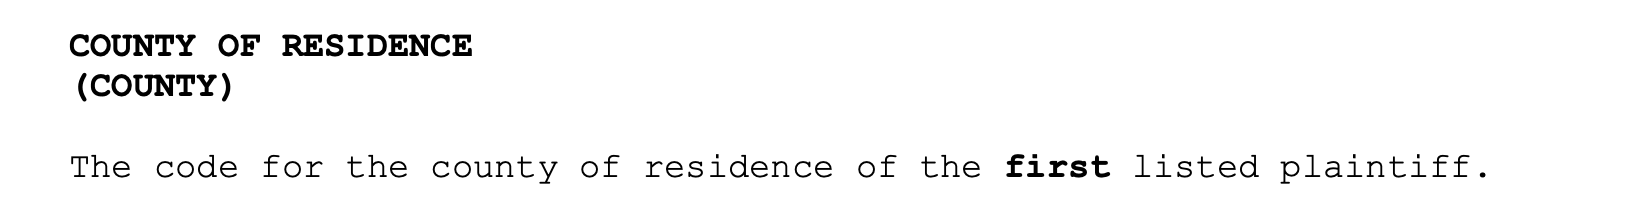

In [74]:
df["COUNTY"].value_counts()

88888    119779
6037      28351
17031     23527
36047     21639
36061     17094
          ...  
31171         1
41021         1
31103         1
20025         1
46075         1
Name: COUNTY, Length: 3184, dtype: int64

In [75]:
df= df.drop(columns=["DOCKET","COUNTY"])

In [110]:
df= df.drop(columns=["RESIDENC"])

### 3.1.2 Visualize unique values in Categorical features with Bar Graph

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

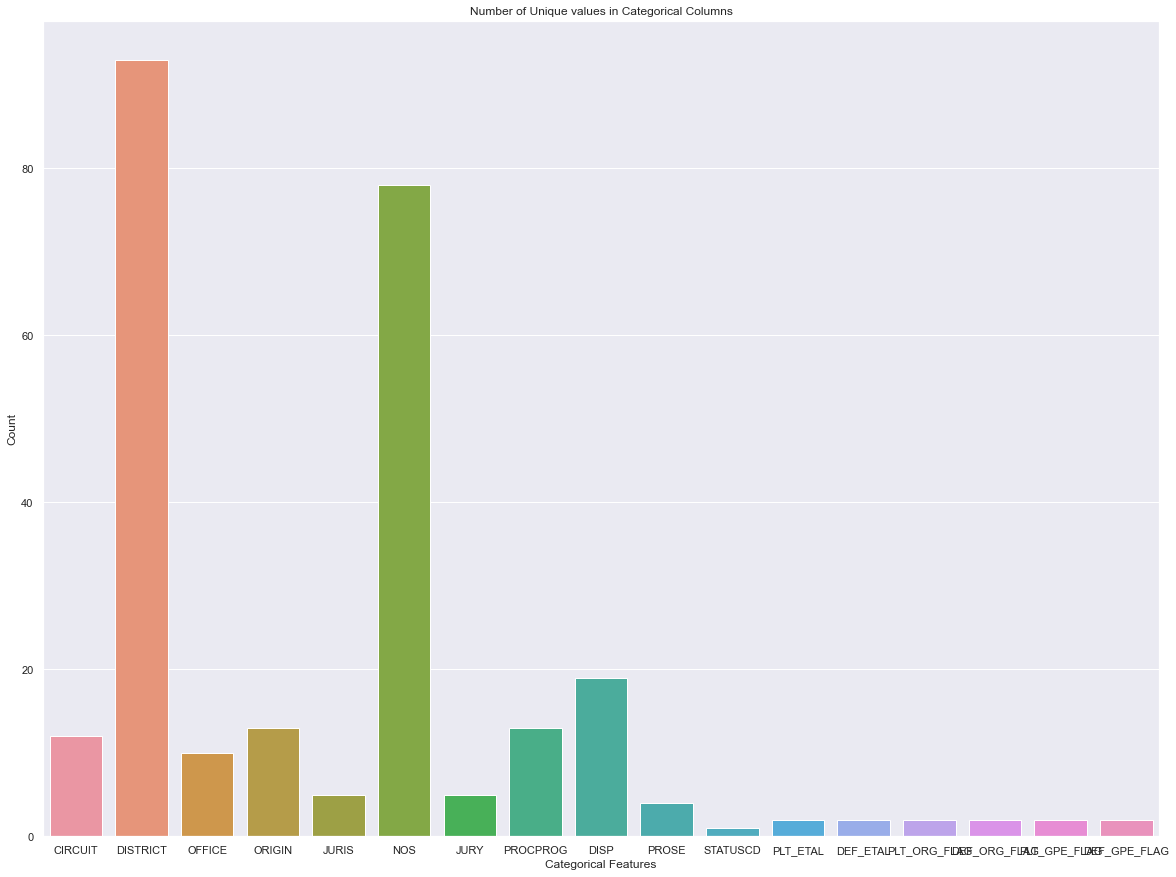

In [111]:
categorical_cols = ['CIRCUIT', 'DISTRICT', 'OFFICE','ORIGIN', 'JURIS', 'NOS','JURY','PROCPROG','DISP','PROSE','STATUSCD', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG','PLT_GPE_FLAG','DEF_GPE_FLAG']
df_cat = df[categorical_cols].copy()
df_cat.nunique()
sns.set(rc={'figure.figsize':(20,15)})
x_uni = df_cat.nunique().index
y_uni = df_cat.nunique().values
ax=sns.barplot(x_uni,y_uni)
##ax.set_yscale("log") ## If values are large
ax.set_title("Number of Unique values in Categorical Columns")
ax.set_xlabel("Categorical Features")
ax.set_ylabel("Count")



---


### 3.1.3 Frequency Mapping


*   There may be unique values in Catergorical features which have very less or negligible frequency
*   These values can be grouped together and replaced by 'Other' Catergory



In [77]:
def freq_map_encoding(column,percent_replace):
  freq = df[column].value_counts(normalize=True)
  mapping = df[column].map(freq)
  df[column] = df[column].mask(mapping < (percent_replace/100), 'Other')
  return df[column]

## column in format: 'column'
## percent_remove: 1 for 1%

In [78]:
cols_to_freq_map = ["NOS","DISTRICT","JURY"]
for cols in cols_to_freq_map:
  df[cols] = freq_map_encoding(cols,0.05)



*   Replaced values which have less than 0/05% frequency with "Other"



---







In [ ]:
df.to_csv("LLrawdata2.csv")

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

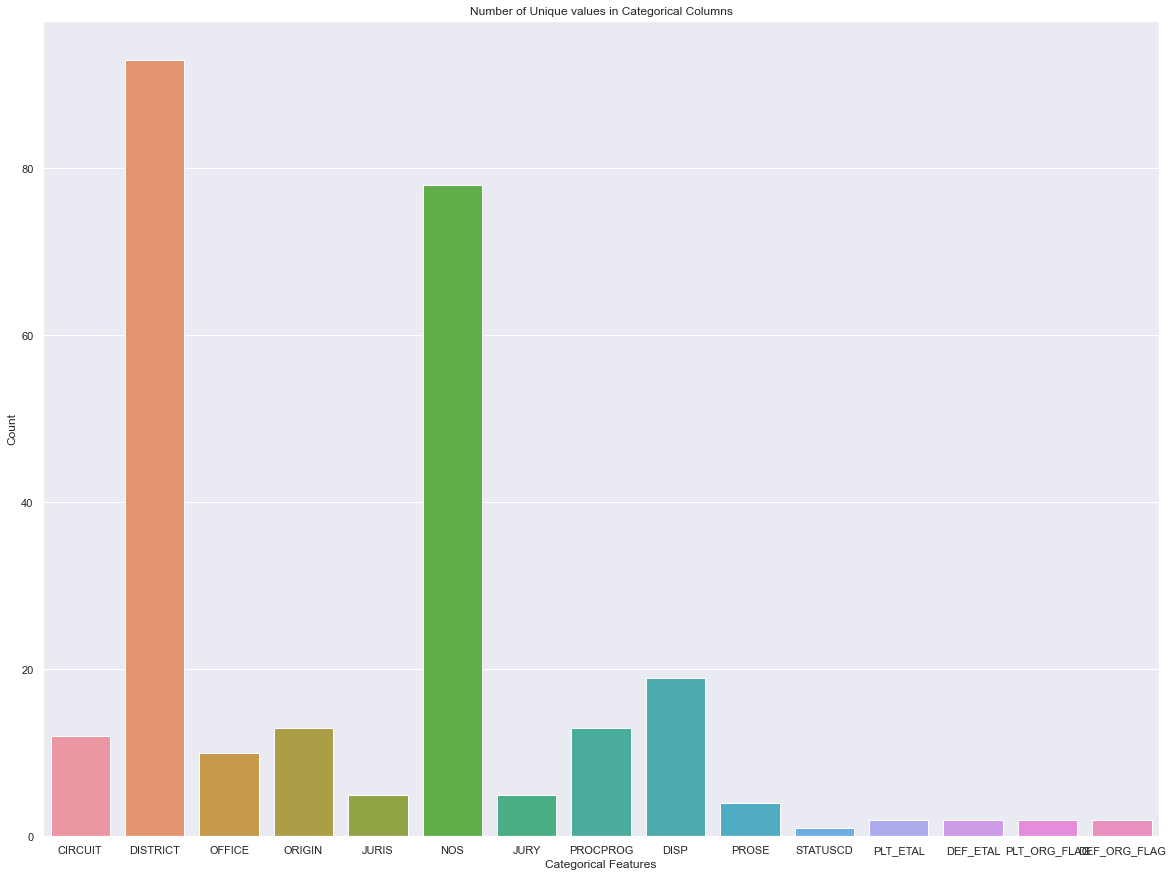

In [79]:
categorical_cols = ['CIRCUIT', 'DISTRICT', 'OFFICE','ORIGIN', 'JURIS', 'NOS','JURY','PROCPROG','DISP','PROSE','STATUSCD', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG','PLT_GPE_FLAG','DEF_GPE_FLAG']
df_cat = df[categorical_cols].copy()
df_cat.nunique()
sns.set(rc={'figure.figsize':(20,15)})
x_uni = df_cat.nunique().index
y_uni = df_cat.nunique().values
ax=sns.barplot(x_uni,y_uni)
##ax.set_yscale("log") ## If values are large
ax.set_title("Number of Unique values in Categorical Columns")
ax.set_xlabel("Categorical Features")
ax.set_ylabel("Count")

In [80]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,JURIS,NOS,RESIDENC,JURY,DEMANDED,PLT,...,PLT_ORG,DEF_ORG,PLT_PERSON,DEF_PERSON,PLT_GPE,DEF_GPE,PLT_ORG_FLAG,DEF_ORG_FLAG,PLT_GPE_FLAG,DEF_GPE_FLAG
3183092,0,90,1,1.0,3.0,Other,NaN,NaN,0.0,"GENERAL COMM/ADJUST, ET AL",...,,,NaN,NaN,NaN,NaN,False,False,False,False
3183095,0,90,1,1.0,2.0,893,NaN,NaN,0.0,"CITY/WILLIAMS, ARIZO, ET AL",...,CITY/WILLIAMS,,NaN,NaN,NaN,NaN,True,False,False,False
3183099,0,90,1,1.0,2.0,890,NaN,NaN,0.0,"LOS ANGELES CO/DHS, ET AL",...,,SHALALA,NaN,NaN,NaN,NaN,False,True,False,False
3183100,0,90,1,1.0,3.0,442,NaN,NaN,2000.0,DAVIS,...,DAVIS,SECURIT,NaN,NaN,NaN,NaN,True,True,False,False
3183104,0,90,1,1.0,2.0,863,NaN,NaN,0.0,YOUNG,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False


In [112]:
df.columns

Index(['CIRCUIT', 'DISTRICT', 'OFFICE', 'ORIGIN', 'JURIS', 'NOS', 'JURY',
       'DEMANDED', 'PLT', 'DEF', 'TDATEUSE', 'PROCPROG', 'DISP', 'NOJ',
       'AMTREC', 'JUDGMENT', 'PROSE', 'STATUSCD', 'TAPEYEAR', 'LABEL_C',
       'CASEDAYS', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG', 'DEF_ORG', 'PLT_PERSON',
       'DEF_PERSON', 'PLT_GPE', 'DEF_GPE', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG',
       'PLT_GPE_FLAG', 'DEF_GPE_FLAG'],
      dtype='object')

## 3.2 Data Preprocessing for all models



1.   One-hot Encoding
2.   Scaling
3.   Label Encoding




In [174]:
##Model 1:
categorical_cols_a = ['CIRCUIT', 'DISTRICT', 'OFFICE','ORIGIN', 'JURIS', 'NOS','JURY','PROSE', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG','PLT_GPE_FLAG','DEF_GPE_FLAG']
numerical_cols_a = ['DEMANDED','CASEDAYS']
label_col_a = ['JUDGMENT']
to_drop_a = ['AMTREC','PLT','DEF',"LABEL_C","NOJ",'TDATEUSE','PROCPROG', 'DISP', 'STATUSCD', 'TAPEYEAR','PLT_ORG', 'DEF_ORG', 'PLT_PERSON','DEF_PERSON', 'PLT_GPE', 'DEF_GPE']

In [175]:
##Model 2:
categorical_cols_b = ['CIRCUIT', 'DISTRICT', 'OFFICE','ORIGIN', 'JURIS', 'NOS','JURY','PROSE', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG','PLT_GPE_FLAG','DEF_GPE_FLAG','NOJ','JUDGMENT']
numerical_cols_b = ['DEMANDED','CASEDAYS','AMTREC']
label_col_b = ['AMTREC']
to_drop_b = ['PLT','DEF',"LABEL_C",'TDATEUSE','PROCPROG', 'DISP', 'STATUSCD', 'TAPEYEAR','PLT_ORG', 'DEF_ORG', 'PLT_PERSON','DEF_PERSON', 'PLT_GPE', 'DEF_GPE']

In [176]:
##Model 3:
categorical_cols_c = ['CIRCUIT', 'DISTRICT', 'OFFICE','ORIGIN', 'JURIS', 'NOS','JURY','PROSE', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG','PLT_GPE_FLAG','DEF_GPE_FLAG']
numerical_cols_c = ['DEMANDED','CASEDAYS']
label_col_c = ['LABEL_C']
to_drop_c = ['PLT','DEF','AMTREC',"NOJ","JUDGMENT",'TDATEUSE','PROCPROG', 'DISP', 'STATUSCD', 'TAPEYEAR','PLT_ORG', 'DEF_ORG', 'PLT_PERSON','DEF_PERSON', 'PLT_GPE', 'DEF_GPE']

In [184]:
## One-Hot Encoding

df_a = pd.get_dummies(df, columns = categorical_cols_a)
df_a = df_a.drop(columns=to_drop_a)
df_a = df_a.reset_index(drop=True)

df_b = pd.get_dummies(df, columns = categorical_cols_b)
df_b = df_b.drop(columns=to_drop_b)
df_b = df_b.reset_index(drop=True)

df_c = pd.get_dummies(df, columns = categorical_cols_c)
df_c = df_c.drop(columns=to_drop_c)
df_c = df_c.reset_index(drop=True)

/opt/homebrew/lib/python3.9/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/opt/homebrew/lib/python3.9/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/opt/homebrew/lib/python3.9/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [185]:
## Scaling numerical columns

df_a[numerical_cols_a] = MinMaxScaler().fit_transform(df_a[numerical_cols_a])
df_b[numerical_cols_b] = MinMaxScaler().fit_transform(df_b[numerical_cols_b])
df_c[numerical_cols_c] = MinMaxScaler().fit_transform(df_b[numerical_cols_c])

In [186]:
## Label Encoding for Classification

labelencoder = LabelEncoder()

df_a["JUDGMENT"] = df_a["JUDGMENT"].astype(int)
df_a["JUDGMENT"] = labelencoder.fit_transform(df_a["JUDGMENT"])
df_a.head()

df_c["LABEL_C"] = df_c["LABEL_C"].astype(int)
df_c["LABEL_C"] = labelencoder.fit_transform(df_c["LABEL_C"])
df_c.head()

,DEMANDED,LABEL_C,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,...,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True,PLT_GPE_FLAG_False,PLT_GPE_FLAG_True,DEF_GPE_FLAG_False,DEF_GPE_FLAG_True
0,0.00000,0,0.015091,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1,0.00000,14,0.015023,1,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
2,0.00000,0,0.017290,1,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,1,0
3,0.20002,7,0.009542,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,0.00000,7,0.008932,1,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [187]:
df_a.columns

Index(['DEMANDED', 'JUDGMENT', 'CASEDAYS', 'CIRCUIT_0', 'CIRCUIT_1',
       'CIRCUIT_2', 'CIRCUIT_3', 'CIRCUIT_4', 'CIRCUIT_5', 'CIRCUIT_6',
       ...
       'DEF_ETAL_False', 'DEF_ETAL_True', 'PLT_ORG_FLAG_False',
       'PLT_ORG_FLAG_True', 'DEF_ORG_FLAG_False', 'DEF_ORG_FLAG_True',
       'PLT_GPE_FLAG_False', 'PLT_GPE_FLAG_True', 'DEF_GPE_FLAG_False',
       'DEF_GPE_FLAG_True'],
      dtype='object', length=235)

In [ ]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

In [ ]:
df_column_switch(df_ohe, 'DEMANDED','LABEL')

,index,LABEL,PLT,DEF,TDATEUSE,AMTREC,TAPEYEAR,DEMANDED,CASEDAYS,PLT_ORG,...,PROSE_3.0,STATUSCD_L,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
0,3183092,0,"GENERAL COMM/ADJUST, ET AL","BURLINGTON NORTHERN, ET AL",03/01/2001,0.0,2001,0.000000,0.015091,ET AL,...,0,1,0,1,0,1,0,1,0,1
1,3183095,14,"CITY/WILLIAMS, ARIZO, ET AL","DOMBECK, ET AL",03/01/2001,0.0,2001,0.000000,0.015023,ARIZO,...,0,1,0,1,0,1,0,1,0,1
2,3183099,0,"LOS ANGELES CO/DHS, ET AL",SHALALA,06/01/2001,0.0,2001,0.000000,0.017290,LOS ANGELES CO/DHS,...,0,1,0,1,1,0,0,1,0,1
3,3183100,7,DAVIS,"COASTAL INTL SECURIT, ET AL",10/01/2000,0.0,2001,0.200020,0.009542,DAVIS,...,0,1,1,0,0,1,0,1,0,1
4,3183104,7,YOUNG,APFEL,10/01/2000,0.0,2001,0.000000,0.008932,NaN,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039961,9474305,7,WILLIAMS,"STATE OF GEORGIA, ET AL",08/01/2021,0.0,2021,0.030003,0.014989,WILLIAMS,...,0,1,1,0,0,1,0,1,0,1
1039962,9474327,3,MONITRONICS INTERNATIONAL INC.,MYERS,12/01/2020,0.0,2021,0.007501,0.004568,MONITRONICS INTERNATIONAL INC,...,0,1,1,0,1,0,0,1,1,0
1039963,9474341,7,KIRKLAND,"LAUGHLIN, ET AL",02/01/2021,0.0,2021,0.000000,0.005075,KIRKLAND,...,0,1,1,0,0,1,0,1,0,1
1039964,9474346,7,JOYNER,UNITED STATES OF AMERICA,06/01/2021,0.0,2021,0.000000,0.007917,NaN,...,0,1,1,0,1,0,1,0,0,1


In [ ]:
## Lower memory size by downcasting

print("Dataframe Info before:\n")
df_ohe.info()
float_cols = df_ohe.select_dtypes('float').columns

int_cols = df_ohe.select_dtypes('integer').columns

df_ohe[float_cols] = df_ohe[float_cols].apply(pd.to_numeric, downcast='float')
df_ohe[int_cols] = df_ohe[int_cols].apply(pd.to_numeric, downcast='integer')
print("\n\nDataframe Info after:\n")
df_ohe.info()

Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039966 entries, 0 to 1039965
Columns: 130 entries, index to DEF_ORG_FLAG_True
dtypes: float64(3), int16(1), int64(2), object(5), uint8(119)
memory usage: 199.3+ MB


Dataframe Info after:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039966 entries, 0 to 1039965
Columns: 130 entries, index to DEF_ORG_FLAG_True
dtypes: float32(3), int16(1), int32(1), int8(120), object(5)
memory usage: 176.5+ MB


In [188]:
def downcast_dataframe(dataframe):
    print("\nDataframe Info before:\n")
    dataframe.info()
    float_cols = dataframe.select_dtypes('float').columns
    int_cols = dataframe.select_dtypes('integer').columns
    dataframe[float_cols] = dataframe[float_cols].apply(pd.to_numeric, downcast='float')
    dataframe[int_cols] = dataframe[int_cols].apply(pd.to_numeric, downcast='integer')
    print("\nDataframe Info After:\n")
    return dataframe.info()

In [189]:
to_downframe = [df_a, df_b, df_c]
for dfs in to_downframe:
    downcast_dataframe(dfs)
    


Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070636 entries, 0 to 1070635
Columns: 235 entries, DEMANDED to DEF_GPE_FLAG_True
dtypes: float64(2), int64(1), uint8(232)
memory usage: 261.4 MB

Dataframe Info After:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070636 entries, 0 to 1070635
Columns: 235 entries, DEMANDED to DEF_GPE_FLAG_True
dtypes: float32(2), int8(233)
memory usage: 246.1 MB

Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070636 entries, 0 to 1070635
Columns: 245 entries, DEMANDED to JUDGMENT_3.0
dtypes: float64(3), uint8(242)
memory usage: 271.6 MB

Dataframe Info After:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070636 entries, 0 to 1070635
Columns: 245 entries, DEMANDED to JUDGMENT_3.0
dtypes: float32(3), int8(242)
memory usage: 259.3 MB

Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070636 entries, 0 to 1070635
Columns: 235 entries, DEMANDED to DEF_GPE_FLAG_True
dty

### 3.2.2 Class imbalance

*   To check class imbalance in Classification models
*   To avoid prediction bias



Model 1:

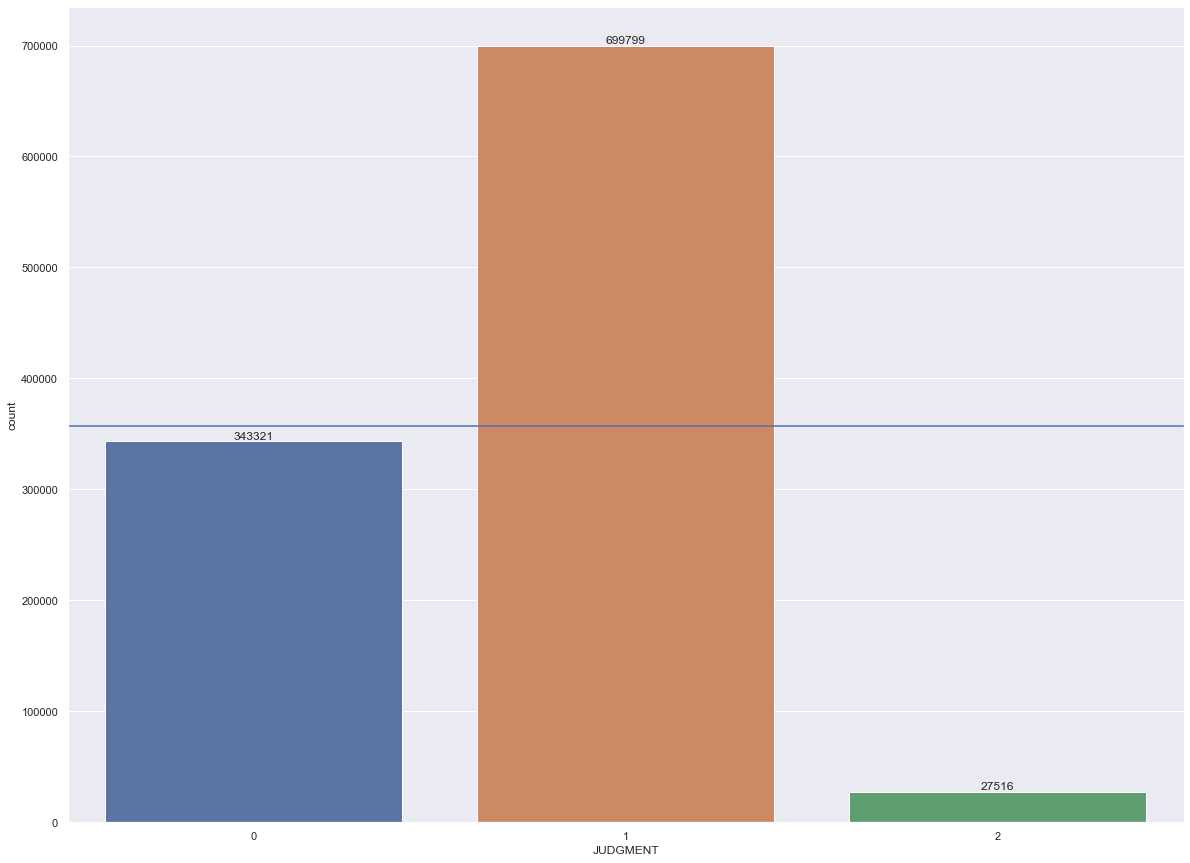

In [190]:
ax=sns.countplot(x="JUDGMENT",data=df_a,order=range(0,3))
#ax.set_yscale("log")
abs_values = df_a["JUDGMENT"].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0],labels=abs_values.sort())
ax.axhline(sum(abs_values)/len(abs_values))     ## Avergae value line



*   Class is imbalanced for Model 1
*   We must oversample minority classes or undersample majority class i.e. level them
*   Or we can use combination of them




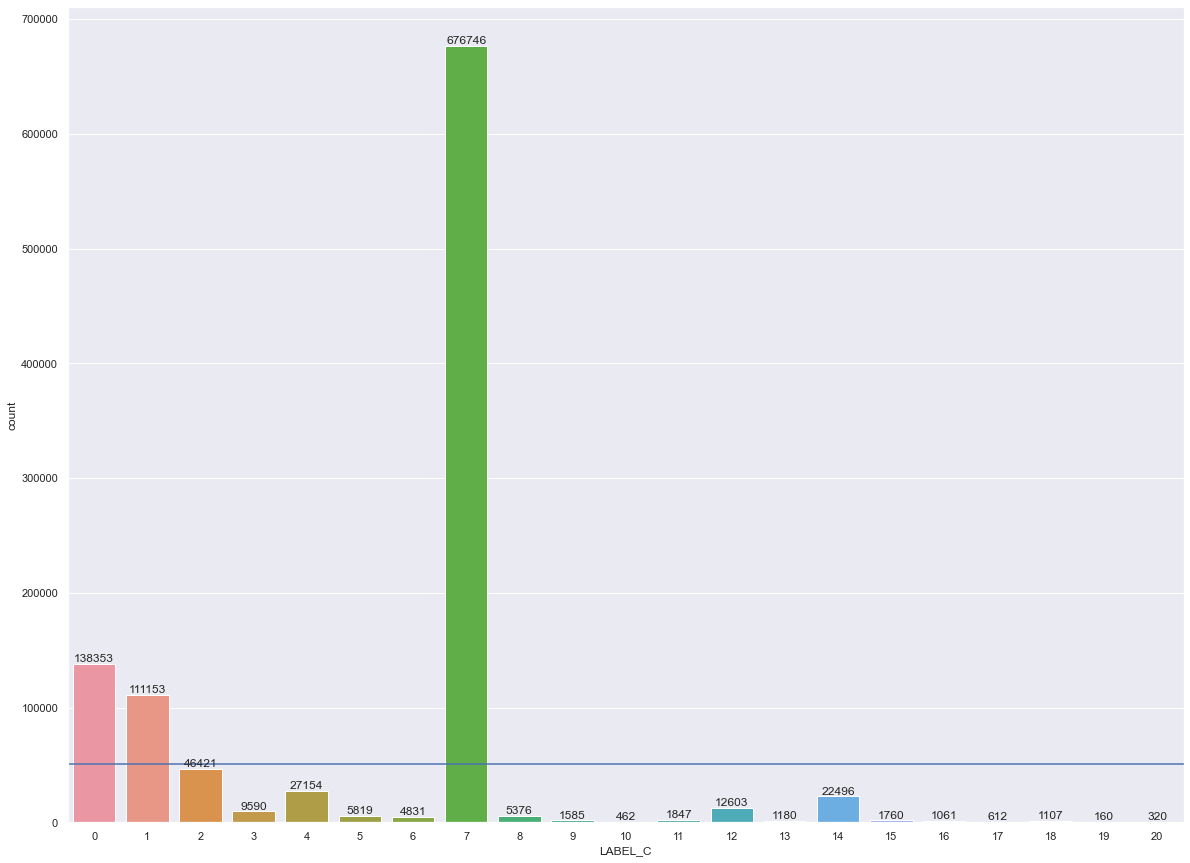

In [191]:
ax=sns.countplot(x="LABEL_C",data=df_c,order=range(0,21))
#ax.set_yscale("log")
abs_values = df_c["LABEL_C"].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0],labels=abs_values.sort())
ax.axhline(sum(abs_values)/len(abs_values))     ## Avergae value line

ADD MODEL 2 distribution

<AxesSubplot:xlabel='AMTREC', ylabel='Count'>

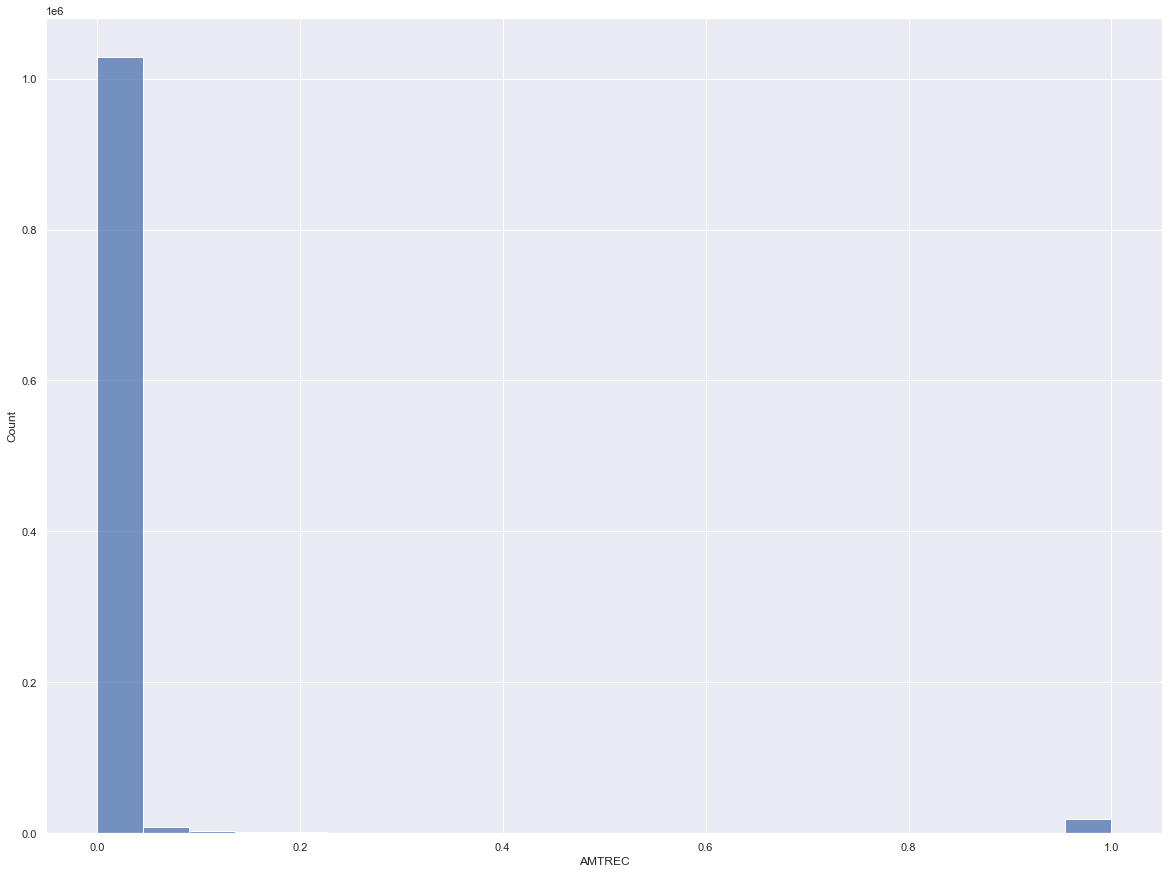

In [193]:
sns.histplot(df_b["AMTREC"])

### 3.2.2.1 Class balance using SMOTE

MODEL 1:

In [194]:
X_df_a = df_a.loc[:,df_a.columns != 'JUDGMENT']
y_df_a = df_a['JUDGMENT']

X_train_a , X_test_a, y_train_a, y_test_a = train_test_split(X_df_a, y_df_a, test_size=0.2,shuffle=True)

In [195]:
strategy = {0:500000, 2:500000}
oversample = SMOTE(sampling_strategy=strategy,random_state=42)

In [196]:
X_train_as, y_train_as = oversample.fit_resample(X_train_a,y_train_a)

In [197]:
X_train_as.sample(n=100)

,DEMANDED,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,CIRCUIT_7,...,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True,PLT_GPE_FLAG_False,PLT_GPE_FLAG_True,DEF_GPE_FLAG_False,DEF_GPE_FLAG_True
550299,0.800080,0.036001,0,0,0,0,0,0,1,0,...,0,1,1,0,1,0,1,0,1,0
963754,0.000000,0.007807,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
662364,0.000000,0.001827,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
767539,0.000000,0.007681,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
999434,0.000000,0.017570,0,0,0,0,0,0,1,0,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43481,0.000000,0.003350,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,1,0,1,0
703500,0.000000,0.008391,0,0,0,0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,1
1250924,0.001045,0.139397,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
516929,1.000000,0.087904,0,0,1,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0


In [198]:
X_train_as.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559539 entries, 0 to 1559538
Columns: 234 entries, DEMANDED to DEF_GPE_FLAG_True
dtypes: float32(2), int8(232)
memory usage: 357.0 MB


In [199]:
all_labels = list(range(0,21))
label_asis = [0, 1, 7]

label_oversamp = [element for element in all_labels if element not in label_asis]
## TODO
''' create a func for dict for over/under sample strategy '''


' create a func for dict for over/under sample strategy '

# 3.3 Classification Using different Classifiers:

### 3.3.1 XGBoost


1.   Setting Parameters



In [200]:
params = {}
params["objective"]= 'multi:softmax'
params["eta"]= 0.1
params["max_depth"]= 6
#params["nthread"]= 4
params["num_class"]= 3
params["eval_metric"]='merror'
params

{'objective': 'multi:softmax',
 'eta': 0.1,
 'max_depth': 6,
 'num_class': 3,
 'eval_metric': 'merror'}



2.   DMatrix



In [201]:
num_round=3
dtrain=xgb.DMatrix(X_train_as,label=y_train_as)
dtest= xgb.DMatrix(X_test_a,label=y_test_a)



3.  Training



In [202]:
bst = xgb.train(params, dtrain)

4. Prediction

In [203]:
pred = bst.predict(dtest)

5. Evaluation

In [204]:
report = classification_report(y_test_a,pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.64      0.71     68397
           1       0.92      0.77      0.84    140260
           2       0.07      0.55      0.13      5471

    accuracy                           0.73    214128
   macro avg       0.60      0.65      0.56    214128
weighted avg       0.86      0.73      0.78    214128



In [205]:
from sklearn.metrics import accuracy_score
#predictions = [round(value) for value in pred]
accuracy = accuracy_score(y_test_a, pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 72.53%


In [206]:
from sklearn.metrics import recall_score
recall = recall_score(y_test_a,pred,average='macro')
print("Recall: %.2f%%" % (recall*100))

Recall: 65.35%


In [207]:
report = classification_report(y_test_a,pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:,:-1]
#print(report_df)

<AxesSubplot:>

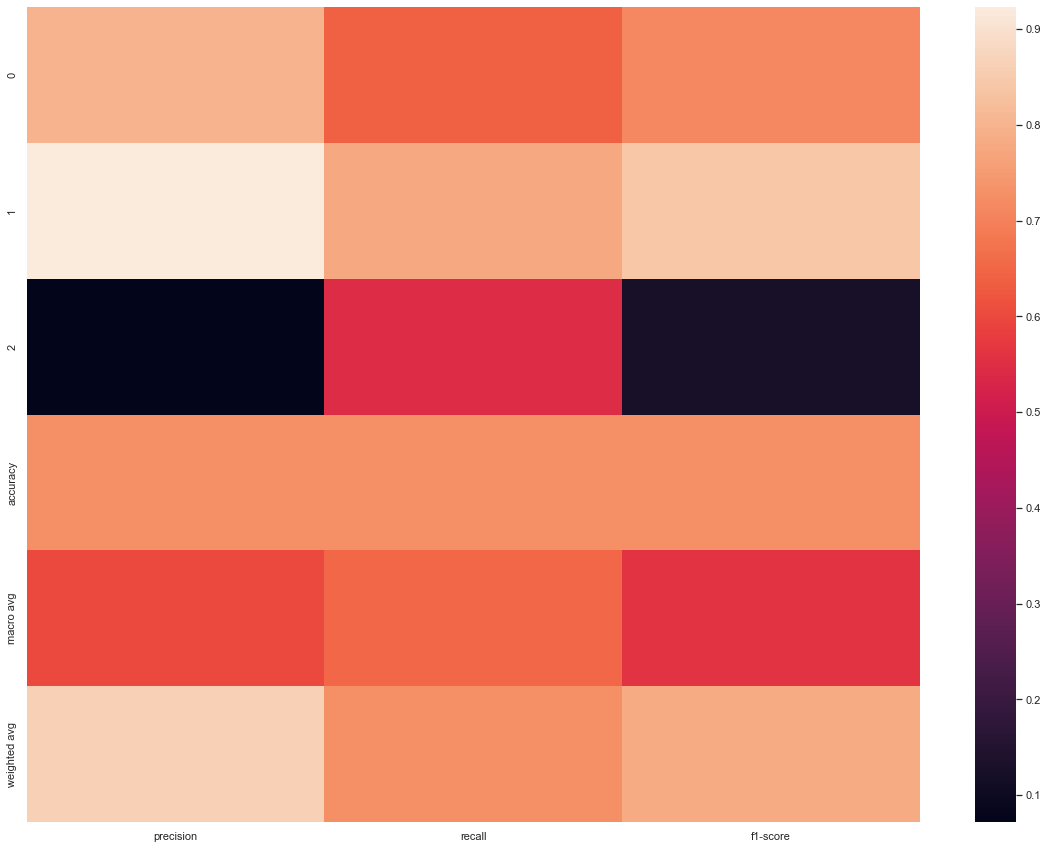

In [208]:
sns.heatmap(report_df)

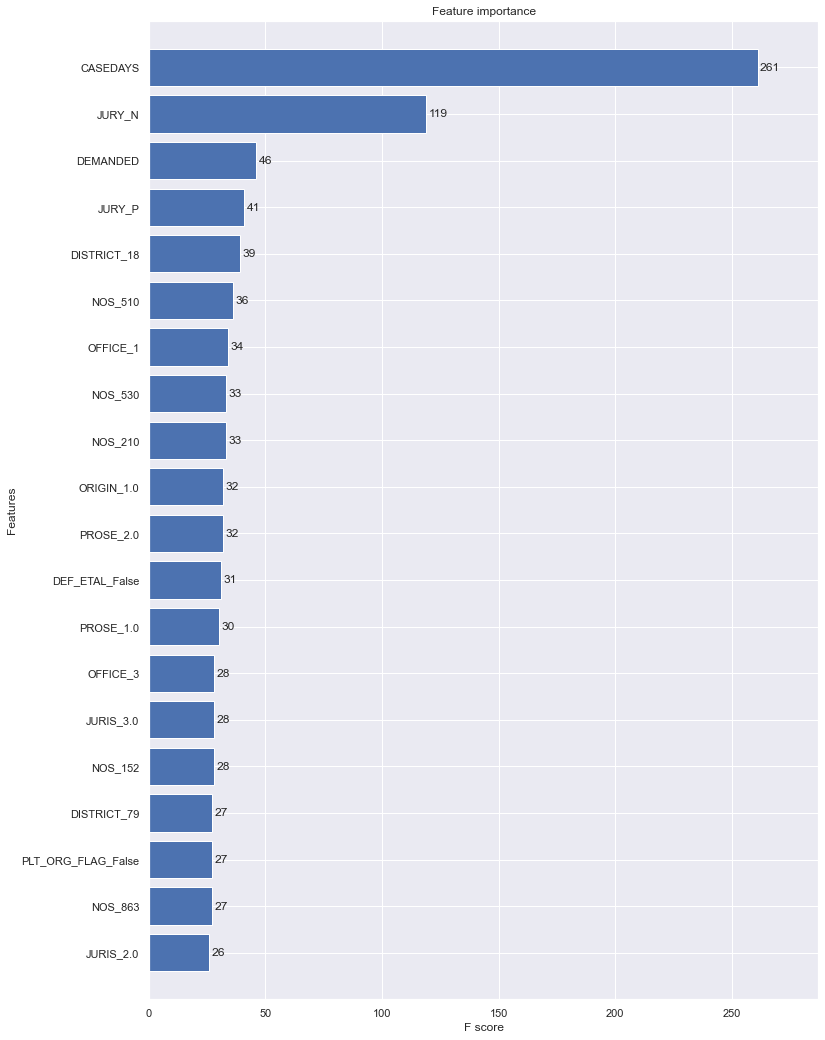

In [209]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=20, height=0.8, ax=ax)
plt.show()

### 3.3.1.6 XGBoost parameter tuning using Bayesian Optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
     params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10), 
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,120)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

## Model 2:

Regression

In [ ]:
X_df_b = df_b.loc[:,df_c.columns != 'AMTREC']
y_df_b = df_b['AMTREC']

X_train_b , X_test_b, y_train_b, y_test_b = train_test_split(X_df_b, y_df_b, test_size=0.2,shuffle=True)

## Model 3:


*   Predicting Nature of Judgement and in favour of
*   Highly imalanced dataset
*   One VS Rest Strategy



In [215]:
X_df_c = df_c.loc[:,df_c.columns != 'LABEL_C']
y_df_c = df_c['LABEL_C']

X_train_c , X_test_c, y_train_c, y_test_c = train_test_split(X_df_c, y_df_c, test_size=0.2,shuffle=True)

In [212]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [213]:
avg_val = 50000
strategy = {2:avg_val, 3:avg_val, 4:avg_val, 5:avg_val, 6:avg_val, 8:avg_val, 9:avg_val, 10:avg_val, 11:avg_val, 12:avg_val, 13:avg_val, 14:avg_val, 15:avg_val, 16:avg_val, 17:avg_val, 18:avg_val, 19:avg_val, 20:avg_val}
oversample = SMOTE(sampling_strategy=strategy)

In [216]:
X_train_cs, y_train_cs = oversample.fit_resample(X_train_c,y_train_c)

In [217]:
X_train_cs.tail()

,DEMANDED,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,CIRCUIT_7,...,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True,PLT_GPE_FLAG_False,PLT_GPE_FLAG_True,DEF_GPE_FLAG_False,DEF_GPE_FLAG_True
1640907,0.000000,0.028573,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
1640908,0.000000,0.060582,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1640909,0.000000,0.012691,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
1640910,0.002632,0.019189,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
1640911,0.000000,0.015439,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,1,0


In [219]:
params3 = {
    'max_depth': 3,
    'objective': 'multi:softmax',  
    'num_class': 21,
    'eval_metric' : 'merror'
}

In [1]:
dtrain3=xgb.DMatrix(X_train_cs,label=y_train_cs)
dtest3= xgb.DMatrix(X_test_c,label=y_test_c)

NameError: name 'xgb' is not defined

In [ ]:
bst3 = xgb.train(params3, dtrain3)

In [ ]:
pred3 = bst.predict(dtest3)

In [ ]:
report3 = classification_report(y_test_c,pred3)
print(report3)

In [ ]:
## Incrimental XGBoost training
import xgboost as xgb
batch_size = 100000
iterations = 2
model = None
for i in range(iterations):
  print("\nIteration:",i+1,"started!\n\n")
  for start in range(0, len(X_train), batch_size):
      start_time = timeit.default_timer()
      model = xgb.train(params, dtrain=xgb.DMatrix(X_train[start:start+batch_size], y_train[start:start+batch_size]), xgb_model=model)
      stop_time = timeit.default_timer()
      y_pred = model.predict(xgb.DMatrix(X_test))
      predictions = [round(value) for value in y_pred]
      accuracy = accuracy_score(y_test, predictions)
      print("Training for Batch of size:", int(start/batch_size)+1,"of",int(len(X_train)/batch_size)+1,"done. Time:",round((stop_time - start_time),1), "seconds.","Accuracy: %.2f%%" % (accuracy*100))      
print("Training Completed!")
y_pred = model.predict(xgb.DMatrix(X_test))

Iteration: 1 started!




/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 1 of 8 done. Time: 39.7 seconds. Accuracy: 81.06%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 2 of 8 done. Time: 40.2 seconds. Accuracy: 81.45%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 3 of 8 done. Time: 40.5 seconds. Accuracy: 81.69%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 4 of 8 done. Time: 41.2 seconds. Accuracy: 81.92%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 5 of 8 done. Time: 41.7 seconds. Accuracy: 82.07%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 6 of 8 done. Time: 41.8 seconds. Accuracy: 82.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 7 of 8 done. Time: 42.2 seconds. Accuracy: 82.38%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 8 of 8 done. Time: 42.2 seconds. Accuracy: 82.51%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 9 of 8 done. Time: 13.6 seconds. Accuracy: 82.58%
Iteration: 2 started!




/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 1 of 8 done. Time: 43.2 seconds. Accuracy: 82.64%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 2 of 8 done. Time: 43.1 seconds. Accuracy: 82.71%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 3 of 8 done. Time: 43.3 seconds. Accuracy: 82.81%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 4 of 8 done. Time: 43.3 seconds. Accuracy: 82.88%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 5 of 8 done. Time: 43.1 seconds. Accuracy: 82.95%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 6 of 8 done. Time: 43.1 seconds. Accuracy: 82.94%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 7 of 8 done. Time: 43.8 seconds. Accuracy: 82.99%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 8 of 8 done. Time: 44.0 seconds. Accuracy: 83.04%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 9 of 8 done. Time: 14.2 seconds. Accuracy: 82.98%
Training Completed!


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 82.98%


In [ ]:
report = classification_report(y_test,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.51      0.02      0.04     27390
           1       0.86      0.00      0.01     21136
           2       0.27      0.00      0.00      9227
           3       0.09      0.02      0.04      1886
           4       0.32      0.04      0.07      5348
           5       0.09      0.01      0.02      1170
           6       0.00      0.00      0.00       976
           7       0.87      0.00      0.00    130971
           8       0.08      0.19      0.11      1020
           9       0.01      0.07      0.02       305
          10       0.00      0.00      0.00        98
          11       0.00      0.00      0.00       372
          12       0.00      0.00      0.00      2454
          13       0.00      0.00      0.00       203
          14       0.01      0.00      0.00      4423
          15       0.01      0.11      0.02       324
          16       0.00      0.00      0.00       218
          17       0.00    

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report = classification_report(y_test,predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:,:-1]
#print(report_df)


              precision    recall  f1-score
0              0.510638  0.021030  0.040396
1              0.858696  0.003738  0.007443
2              0.270270  0.001084  0.002159
3              0.094828  0.023330  0.037447
4              0.324881  0.038332  0.068573
5              0.093567  0.013675  0.023863
6              0.000000  0.000000  0.000000
7              0.866667  0.000993  0.001983
8              0.080571  0.188235  0.112842
9              0.010338  0.072131  0.018085
10             0.000000  0.000000  0.000000
11             0.000000  0.000000  0.000000
12             0.000000  0.000000  0.000000
13             0.000000  0.000000  0.000000
14             0.008895  0.001583  0.002687
15             0.008956  0.108025  0.016541
16             0.000000  0.000000  0.000000
17             0.000889  0.388060  0.001774
18             0.000000  0.000000  0.000000
19             0.000194  0.071429  0.000387
20             0.000401  0.742424  0.000801
accuracy       0.006822  0.00682

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

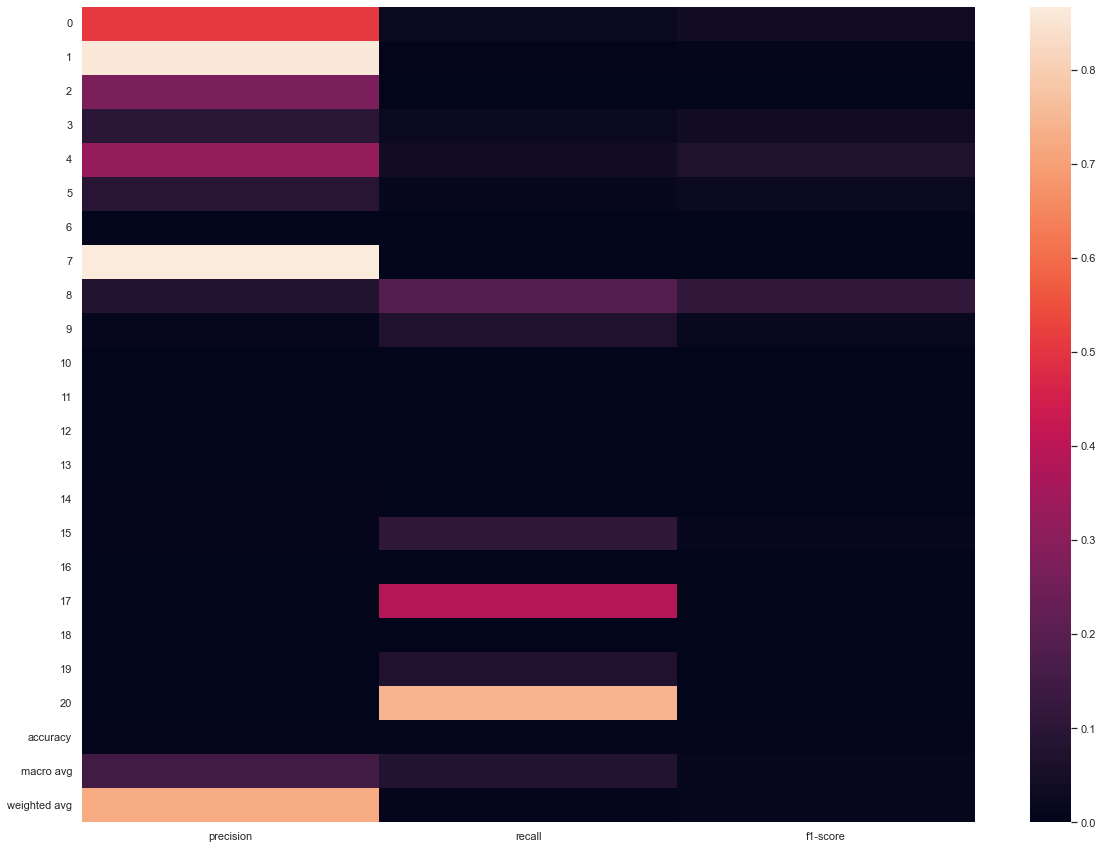

In [ ]:
sns.heatmap(report_df)

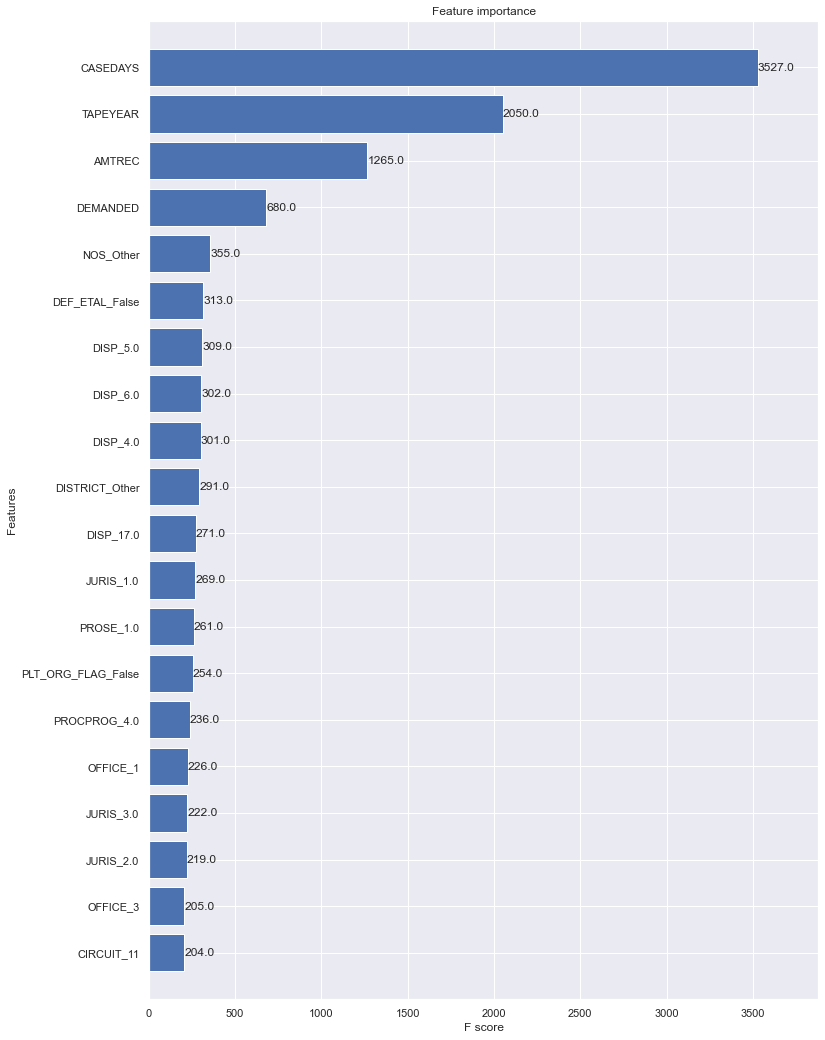

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [ ]:
params = {
    'max_depth': 3,
    'objective': 'multi:softmax',  
    'num_class': 21,
    'eval_metric' : 'merror'
}

In [ ]:
## Incrimental XGBoost training
import xgboost as xgb
batch_size = 200000
iterations = 2
model = None

for i in range(iterations):
  print("\nIteration:",i+1,"started!\n\n")
  for start in range(0, len(X_train_smote), batch_size):
      start_time = timeit.default_timer()
      model = xgb.train(params, dtrain=xgb.DMatrix(X_train_smote[start:start+batch_size], y_train_smote[start:start+batch_size]), xgb_model=model)
      stop_time = timeit.default_timer()
      y_pred = model.predict(xgb.DMatrix(X_test))
      predictions = [round(value) for value in y_pred]
      accuracy = accuracy_score(y_test, predictions)
      print("Training for Batch of size:", int(start/batch_size)+1,"of",int(len(X_train_smote)/batch_size)+1,"done. Time:",round((stop_time - start_time),1), "seconds.","Accuracy: %.2f%%" % (accuracy*100))      
print("Training Completed!")
y_pred = model.predict(xgb.DMatrix(X_test))


Iteration: 1 started!


Training for Batch of size: 1 of 9 done. Time: 79.6 seconds. Accuracy: 81.09%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 2 of 9 done. Time: 81.0 seconds. Accuracy: 81.46%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 3 of 9 done. Time: 83.2 seconds. Accuracy: 81.78%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 4 of 9 done. Time: 82.9 seconds. Accuracy: 82.00%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 5 of 9 done. Time: 86.7 seconds. Accuracy: 63.17%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 6 of 9 done. Time: 46.7 seconds. Accuracy: 0.50%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 7 of 9 done. Time: 42.7 seconds. Accuracy: 21.07%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 8 of 9 done. Time: 40.0 seconds. Accuracy: 0.21%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 9 of 9 done. Time: 2.8 seconds. Accuracy: 0.21%

Iteration: 2 started!




/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 1 of 9 done. Time: 33.9 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 2 of 9 done. Time: 30.4 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 3 of 9 done. Time: 30.3 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 4 of 9 done. Time: 30.0 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 5 of 9 done. Time: 29.7 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 6 of 9 done. Time: 47.5 seconds. Accuracy: 24.58%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 7 of 9 done. Time: 61.1 seconds. Accuracy: 20.54%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 8 of 9 done. Time: 53.8 seconds. Accuracy: 4.01%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 9 of 9 done. Time: 3.2 seconds. Accuracy: 0.68%
Training Completed!


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 0.68%


In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_pred_prob = tree.predict

In [ ]:
roc_auc_score(y_test, predictions,multi_class="ovr")

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
from dask.distributed import Client
client = Client(threads_per_worker=4)
client

/opt/homebrew/lib/python3.9/site-packages/distributed/node.py:181: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53452 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53452/status,
Dashboard: http://127.0.0.1:53452/status,Workers: 2
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53453,Workers: 2
Dashboard: http://127.0.0.1:53452/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:53461,Total threads: 4
Dashboard: http://127.0.0.1:53463/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53457,


In [ ]:
client.close()

In [ ]:
df_dask = dd.from_pandas(df_ohe, chunksize=100000)
df_dask

,DEMANDED,AMTREC,TAPEYEAR,LABEL,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,CIRCUIT_7,CIRCUIT_8,CIRCUIT_9,CIRCUIT_10,CIRCUIT_11,DISTRICT_1,DISTRICT_6,DISTRICT_7,DISTRICT_8,DISTRICT_9,DISTRICT_12,DISTRICT_13,DISTRICT_15,DISTRICT_16,DISTRICT_17,DISTRICT_18,DISTRICT_20,DISTRICT_22,DISTRICT_30,DISTRICT_31,DISTRICT_32,DISTRICT_33,DISTRICT_35,DISTRICT_39,DISTRICT_41,DISTRICT_42,DISTRICT_43,DISTRICT_45,DISTRICT_47,DISTRICT_52,DISTRICT_55,DISTRICT_60,DISTRICT_64,DISTRICT_70,DISTRICT_71,DISTRICT_72,DISTRICT_73,DISTRICT_74,DISTRICT_79,DISTRICT_81,DISTRICT_82,DISTRICT_Other,OFFICE_0,OFFICE_1,OFFICE_2,OFFICE_3,OFFICE_4,OFFICE_5,OFFICE_6,OFFICE_7,OFFICE_8,OFFICE_9,ORIGIN_1.0,ORIGIN_2.0,ORIGIN_3.0,ORIGIN_4.0,ORIGIN_5.0,ORIGIN_6.0,ORIGIN_7.0,ORIGIN_8.0,ORIGIN_9.0,ORIGIN_10.0,ORIGIN_11.0,ORIGIN_12.0,ORIGIN_13.0,JURIS_1.0,JURIS_2.0,JURIS_3.0,JURIS_4.0,JURIS_5.0,NOS_110,NOS_152,NOS_190,NOS_220,NOS_360,NOS_365,NOS_367,NOS_440,NOS_442,NOS_510,NOS_530,NOS_550,NOS_555,NOS_625,NOS_710,NOS_791,NOS_820,NOS_840,NOS_850,NOS_863,NOS_864,NOS_890,NOS_Other,JURY_B,JURY_D,JURY_N,JURY_Other,JURY_P,PROCPROG_1.0,PROCPROG_2.0,PROCPROG_3.0,PROCPROG_4.0,PROCPROG_5.0,PROCPROG_6.0,PROCPROG_7.0,PROCPROG_8.0,PROCPROG_9.0,PROCPROG_10.0,PROCPROG_11.0,PROCPROG_12.0,PROCPROG_13.0,DISP_1.0,DISP_2.0,DISP_3.0,DISP_4.0,DISP_5.0,DISP_6.0,DISP_7.0,DISP_8.0,DISP_9.0,DISP_11.0,DISP_12.0,DISP_13.0,DISP_14.0,DISP_15.0,DISP_16.0,DISP_17.0,DISP_18.0,DISP_19.0,DISP_20.0,PROSE_0.0,PROSE_1.0,PROSE_2.0,PROSE_3.0,STATUSCD_L,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
npartitions=11,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float32,float32,int16,int8,float32,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8
100000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
X_dfdd = df_dask.loc[:,df_dask.columns != 'LABEL']
y_dfdd = df_dask['LABEL']

In [ ]:
X_ddtrain, X_ddtest = X_dfdd.random_split([0.9, 0.1], 
                                         random_state=1234)
y_ddtrain, y_ddtest = y_dfdd.random_split([0.9, 0.1], 
                                                    random_state=1234)

In [ ]:
dtrain = xgb.dask.DaskDMatrix(client, X_ddtrain, y_ddtrain)

In [ ]:
start = time.time()
bst = dask_xgboost.train(client, params, X_ddtrain, y_ddtrain)
end = time.time()
print(end-start)

Exception in thread Thread-25:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/lib/python3.9/site-packages/dask_xgboost/tracker.py", line 365, in join
    while self.thread.isAlive():
AttributeError: 'Thread' object has no attribute 'isAlive'
/opt/homebrew/lib/python3.9/site-packages/dask_xgboost/__init__.py:7: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packag

XGBoostError: [03:10:08] /private/var/folders/qz/s_n3qtjs3vzgtt_wv0_k5hyc0000gn/T/pip-install-7cvka3nb/xgboost_82495ce8a4034d4ba30792fe8ae27643/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:959: Check failed: header == serialisation_header_: 

  If you are loading a serialized model (like pickle in Python) generated by older
  XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version.  There's a simple script for helping
  the process. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for reference to the script, and more details about differences between saving model and
  serializing.


Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000147912468 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001479a6cd4 xgboost::LearnerIO::Load(dmlc::Stream*) + 956
  [bt] (2) 3   libxgboost.dylib                    0x000000014790d4fc XGBoosterUnserializeFromBuffer + 128
  [bt] (3) 4   libffi.dylib                        0x00000001d0f90050 ffi_call_SYSV + 80
  [bt] (4) 5   libffi.dylib                        0x00000001d0f989e4 ffi_call_int + 948
  [bt] (5) 6   _ctypes.cpython-39-darwin.so        0x0000000101bc0eb8 _ctypes_callproc + 864
  [bt] (6) 7   _ctypes.cpython-39-darwin.so        0x0000000101bbb934 PyCFuncPtr_call + 220
  [bt] (7) 8   Python                              0x0000000101596a2c _PyObject_MakeTpCall + 132
  [bt] (8) 9   Python                              0x000000010168f554 call_function + 268



In [ ]:
predictions = dask_xgboost.predict(client, bst, X_ddtest).persist()
predictions.head()

NameError: name 'bst' is not defined